In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger


from lightning.pytorch.tuner import Tuner
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, QuantileLoss
# from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameter

C:\Users\ortek\AppData\Local\Temp\ipykernel_28588\1235657153.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


Benchmark

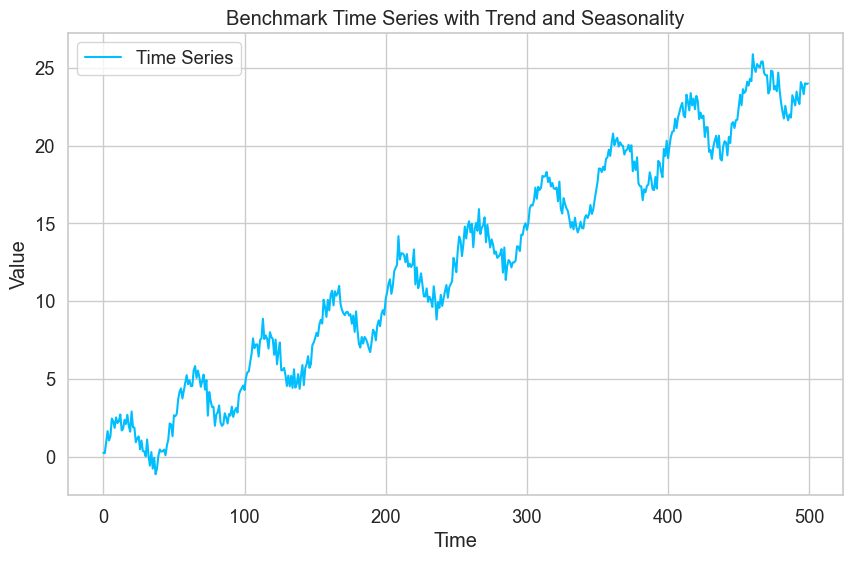

In [2]:
from functions_for_notebook import create_benchmark_data

%matplotlib inline
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

Colour_Palette = ["#01BEFE", "#FF7D00", "#FFDD00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(Colour_Palette))

n_points = 500
data, time_series, t = create_benchmark_data(n_points)


# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(data["Time"], data["Value"], label="Time Series")
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Benchmark Time Series with Trend and Seasonality")
plt.legend()
plt.show()

# Save the data to a CSV file
data.to_csv("benchmark_time_series.csv", index=False)

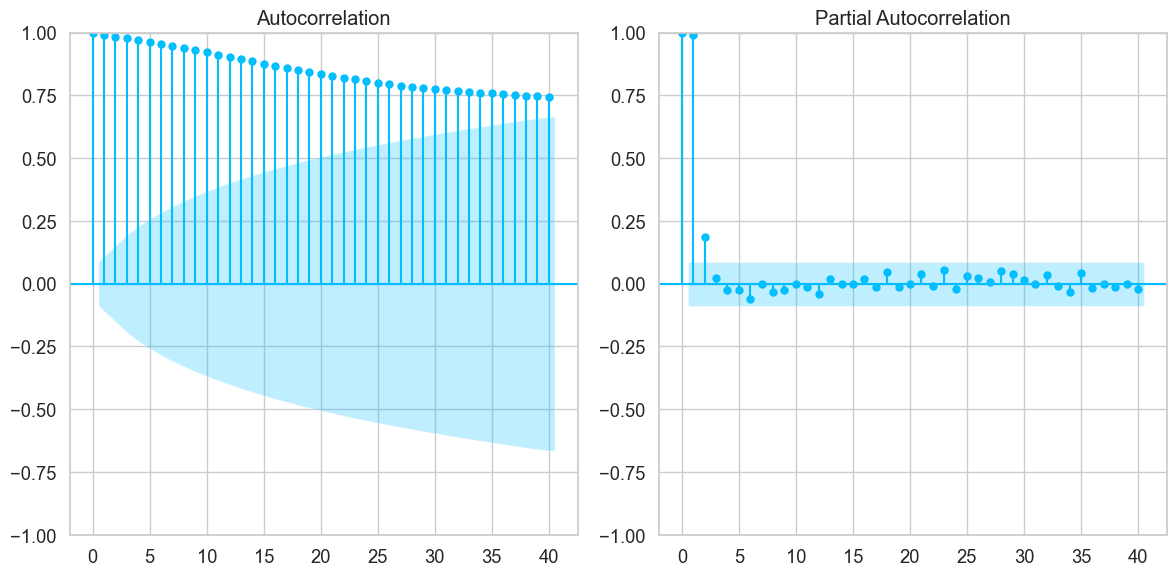

In [4]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(data["Value"], ax=plt.gca(), lags=40)
plt.title("Autocorrelation")
plt.subplot(122)
plot_pacf(data["Value"], ax=plt.gca(), lags=40, method="ywm")
plt.title("Partial Autocorrelation")
plt.tight_layout()
plt.show()

SARIMA seasone 50

In [4]:
seasonal_period = 50  # Same as in the data generation
sarima_model = SARIMAX(
    data["Value"], order=(2, 1, 2), seasonal_order=(1, 1, 1, seasonal_period)
).fit()

In [5]:
# Print model summary
print(sarima_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                Value   No. Observations:                  500
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 50)   Log Likelihood                -377.099
Date:                              Sun, 05 Jan 2025   AIC                            768.198
Time:                                      12:53:04   BIC                            796.947
Sample:                                           0   HQIC                           779.530
                                              - 500                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8032      0.387     -2.074      0.038      -1.562      -0.044
ar.L2         -0.01

In [6]:
# Forecast future values
forecast_steps = 50
forecast = sarima_model.get_forecast(steps=forecast_steps)
forecast_index = np.arange(n_points, n_points + forecast_steps)
forecast_values = forecast.predicted_mean
forecast_ci = forecast.conf_int()

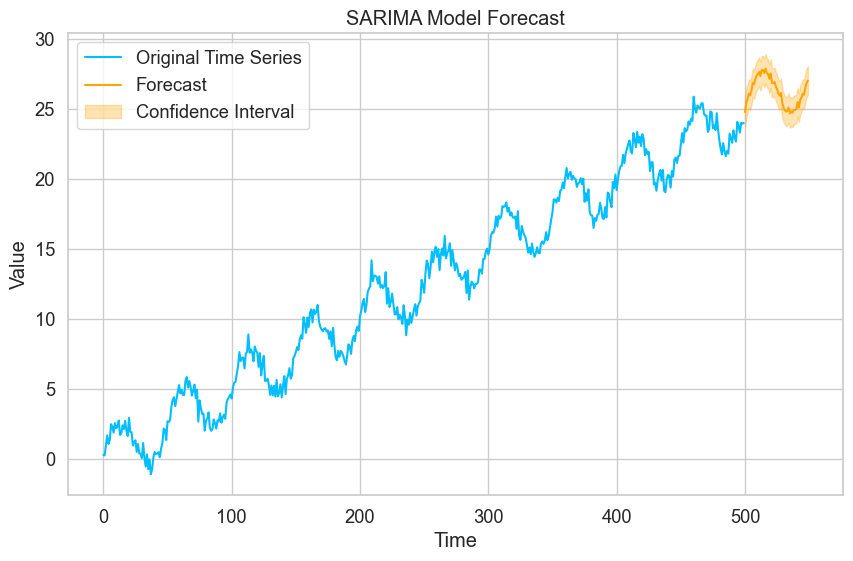

In [7]:
# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(data["Time"], data["Value"], label="Original Time Series")
plt.plot(forecast_index, forecast_values, label="Forecast", color="orange")
plt.fill_between(
    forecast_index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    color="orange",
    alpha=0.3,
    label="Confidence Interval",
)
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("SARIMA Model Forecast")
plt.legend()
plt.show()

Rekurencyjne sieci neuronowe

In [3]:
from functions_for_notebook import data_transformation

(
    train_data,
    test_data,
    scaled_train,
    scaled_test,
    dataset_train,
    dataset_test,
    scaler,
) = data_transformation(data, 0.8)

In [4]:
from functions_for_notebook import create_sequences

sequence_length = 50  # Number of time steps to look back
X_train, y_train = create_sequences(scaled_train, sequence_length)
X_test, y_test = create_sequences(scaled_test, sequence_length)

print(y_train[0])

[0.17291092]


In [5]:
# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
print(X_train.shape, y_train.shape)

# Convert data to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
print(X_test.shape, y_test.shape)

torch.Size([350, 50, 1]) torch.Size([350, 1])
torch.Size([50, 50, 1]) torch.Size([50, 1])


In [6]:
from models import SimpleRNN

input_size = 1
hidden_size = 20
output_size = 1
model_rnn = SimpleRNN(input_size, hidden_size, output_size)
loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model_rnn.parameters(), lr=1e-3)  # Learning rate
batch_size = 16  # Adjusted batch size
# Wraping in torch dataset data type
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_epochs = 50  # Increased number of epochs
train_hist = []
test_hist = []

Cuda check

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.cuda.get_device_name(0))

True
12.1
NVIDIA GeForce RTX 4060 Ti


In [8]:
# Załadowanie modelu do Cuda
model_rnn.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model_rnn.parameters(), lr=0.001)
# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    total_loss = 0.0
    model_rnn.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        predictions = model_rnn(batch_X)
        loss = loss_fn(predictions, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    train_hist.append(average_loss)

    model_rnn.eval()
    with torch.no_grad():
        total_test_loss = 0.0

        for batch_X_test, batch_y_test in test_loader:
            batch_X_test, batch_y_test = (
                batch_X_test.to(device),
                batch_y_test.to(device),
            )
            predictions_test = model_rnn(batch_X_test)
            test_loss = loss_fn(predictions_test, batch_y_test)

            total_test_loss += test_loss.item()

        average_test_loss = total_test_loss / len(test_loader)
        test_hist.append(average_test_loss)

    if (epoch + 1) % 10 == 0:
        print(
            f"Epoch [{epoch + 1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}"
        )

Epoch [10/100] - Training Loss: 0.0024, Test Loss: 0.0119
Epoch [20/100] - Training Loss: 0.0011, Test Loss: 0.0090
Epoch [30/100] - Training Loss: 0.0009, Test Loss: 0.0093
Epoch [40/100] - Training Loss: 0.0009, Test Loss: 0.0102
Epoch [50/100] - Training Loss: 0.0009, Test Loss: 0.0113
Epoch [60/100] - Training Loss: 0.0009, Test Loss: 0.0106
Epoch [70/100] - Training Loss: 0.0008, Test Loss: 0.0112
Epoch [80/100] - Training Loss: 0.0008, Test Loss: 0.0102
Epoch [90/100] - Training Loss: 0.0010, Test Loss: 0.0100
Epoch [100/100] - Training Loss: 0.0009, Test Loss: 0.0104


In [9]:
from functions_for_notebook import print_gpu_memory

print_gpu_memory()
torch.cuda.empty_cache()
print_gpu_memory()

Allocated memory: 16.27 MB
Cached memory: 42.00 MB
Allocated memory: 16.27 MB
Cached memory: 22.00 MB


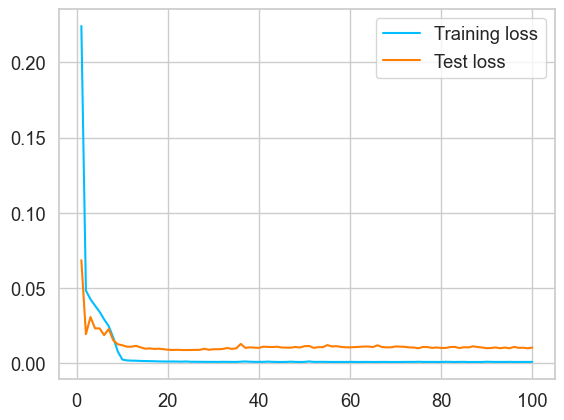

In [10]:
x = np.linspace(1, num_epochs, num_epochs)
plt.plot(x, train_hist, scalex=True, label="Training loss")
plt.plot(x, test_hist, label="Test loss")
plt.legend()
plt.show()

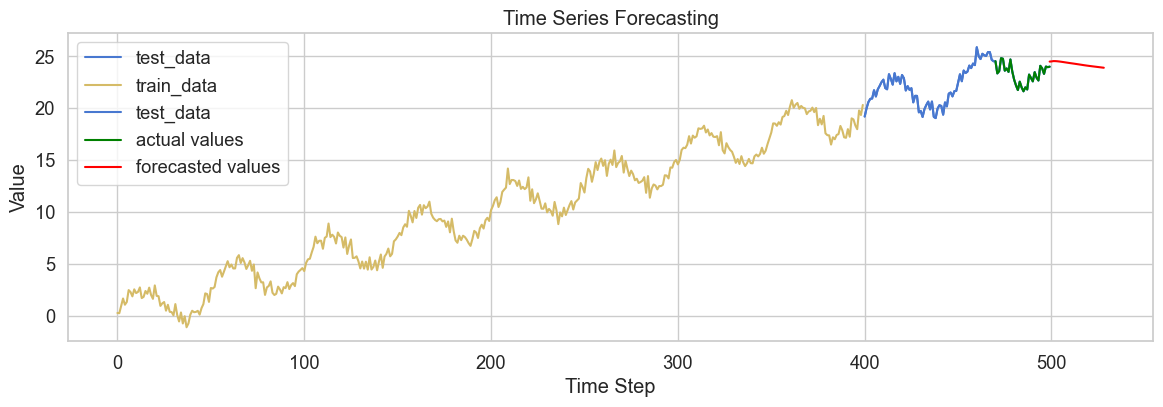

RMSE: 0.1081
R² Score: 0.5090


In [11]:
from functions_for_notebook import forecast_model, model_eval

forecasted_values = forecast_model(
    model=model_rnn, device=device, X_test=X_test, num_forecast_steps=30
)

last_number = test_data.index[-1]
periods = 29
future_dates = pd.Series(range(last_number, last_number + 1 + periods))

plt.rcParams["figure.figsize"] = [14, 4]
plt.plot(test_data.index[-100:], test_data.Value[-100:], label="test_data", color="b")
plt.plot(train_data.index, train_data.Value, label="train_data", color="y")
plt.plot(test_data.index[-300:], test_data.Value[-300:], label="test_data", color="b")
plt.plot(
    test_data.index[-30:], test_data.Value[-30:], label="actual values", color="green"
)
plt.plot(
    future_dates,
    scaler.inverse_transform(np.array(forecasted_values).reshape(-1, 1)).flatten(),
    label="forecasted values",
    color="red",
)

plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.title("Time Series Forecasting")
plt.grid(True)
plt.show()

rmse, r2 = model_eval(model=model_rnn, X_test=X_test, y_test=y_test, device=device)

print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Model LSTM

In [12]:
from models import LSTMModel

input_size = 1
num_layers = 3  # Increased number of layers
hidden_size = 128  # Increased number of hidden units
output_size = 1
dropout = 0.2  # Added dropout for regularization

model_lstm = LSTMModel(input_size, hidden_size, num_layers, dropout).to(device)
loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model_lstm.parameters(), lr=1e-3)  # Learning rate

In [13]:
model_lstm.to(device)

batch_size = 16  # Adjusted batch size

# Wraping in torch dataset data type
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_epochs = 50  # Increased number of epochs
train_hist = []
test_hist = []

for epoch in range(num_epochs):
    total_loss = 0.0
    model_lstm.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        predictions = model_lstm(batch_X)
        loss = loss_fn(predictions, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    train_hist.append(average_loss)

    model_lstm.eval()
    with torch.no_grad():
        total_test_loss = 0.0

        for batch_X_test, batch_y_test in test_loader:
            batch_X_test, batch_y_test = (
                batch_X_test.to(device),
                batch_y_test.to(device),
            )
            predictions_test = model_lstm(batch_X_test)
            test_loss = loss_fn(predictions_test, batch_y_test)

            total_test_loss += test_loss.item()

        average_test_loss = total_test_loss / len(test_loader)
        test_hist.append(average_test_loss)

    if (epoch + 1) % 10 == 0:
        print(
            f"Epoch [{epoch + 1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}"
        )

Epoch [10/50] - Training Loss: 0.0040, Test Loss: 0.0219
Epoch [20/50] - Training Loss: 0.0022, Test Loss: 0.0123
Epoch [30/50] - Training Loss: 0.0015, Test Loss: 0.0127
Epoch [40/50] - Training Loss: 0.0014, Test Loss: 0.0123
Epoch [50/50] - Training Loss: 0.0012, Test Loss: 0.0127


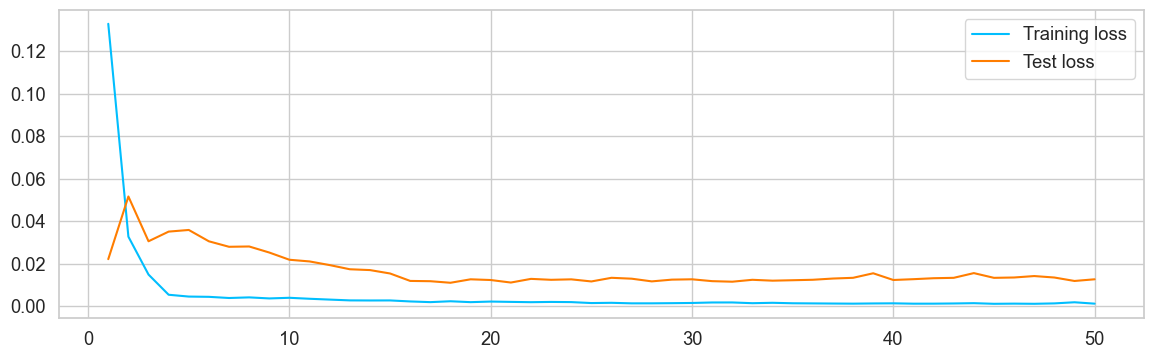

In [15]:
x = np.linspace(1, num_epochs, num_epochs)
plt.plot(x, train_hist, scalex=True, label="Training loss")
plt.plot(x, test_hist, label="Test loss")
plt.legend()
plt.show()

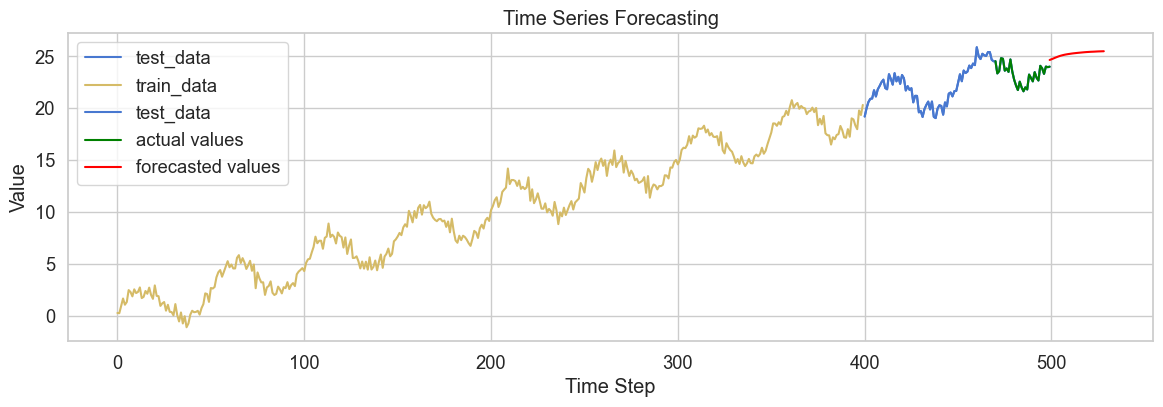

RMSE: 0.1176
R² Score: 0.4182


In [16]:
forecasted_values = forecast_model(
    model=model_lstm, device=device, X_test=X_test, num_forecast_steps=30
)
last_number = test_data.index[-1]
periods = 29
future_dates = pd.Series(range(last_number, last_number + 1 + periods))

plt.rcParams["figure.figsize"] = [14, 4]
plt.plot(test_data.index[-100:], test_data.Value[-100:], label="test_data", color="b")
plt.plot(train_data.index, train_data.Value, label="train_data", color="y")
plt.plot(test_data.index[-300:], test_data.Value[-300:], label="test_data", color="b")
plt.plot(
    test_data.index[-30:], test_data.Value[-30:], label="actual values", color="green"
)
plt.plot(
    future_dates,
    scaler.inverse_transform(np.array(forecasted_values).reshape(-1, 1)).flatten(),
    label="forecasted values",
    color="red",
)

plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.title("Time Series Forecasting")
plt.grid(True)
plt.show()

rmse, r2 = model_eval(model=model_lstm, X_test=X_test, y_test=y_test, device=device)

print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

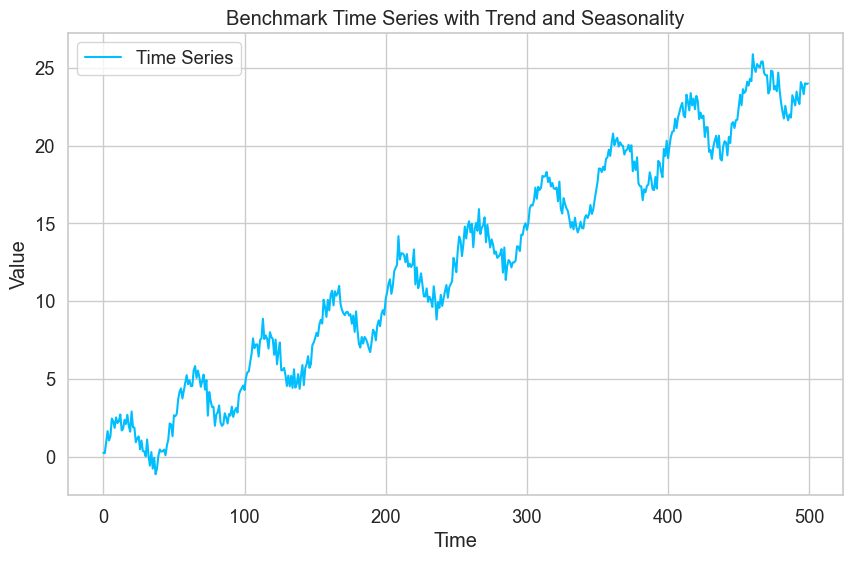

In [17]:
# Create a DataFrame
Data = pd.DataFrame({"Time": t, "Value": time_series})

# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(Data["Time"], Data["Value"], label="Time Series")
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Benchmark Time Series with Trend and Seasonality")
plt.legend()
plt.show()

In [18]:
Data2 = Data[:450]
scaler = MinMaxScaler(feature_range=(0, 1))
# Scaling dataset
data_value = Data2.Value
data_value = np.reshape(data_value, (-1, 1))
scaled_value = scaler.fit_transform(data_value)
scaled_value = np.array(scaled_value)
data_value = torch.tensor(scaled_value, dtype=torch.float32)

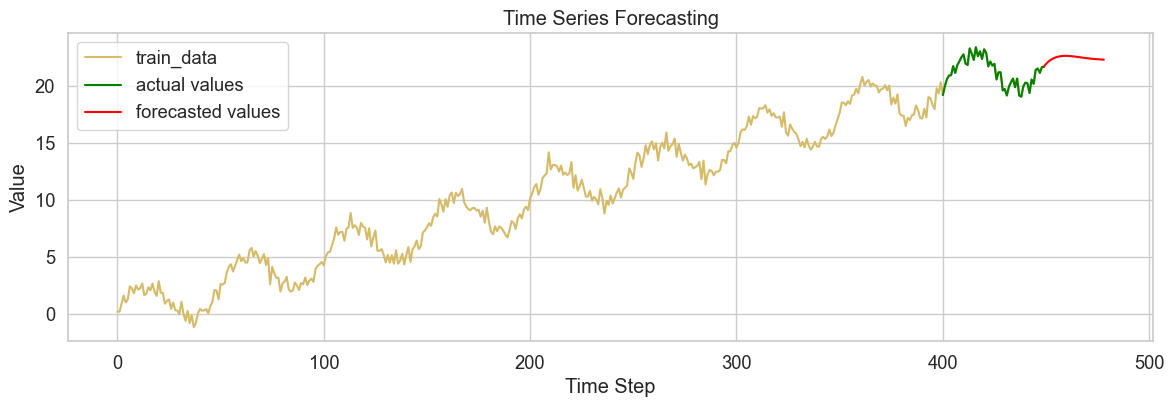

In [19]:
from functions_for_notebook import forecast_model_on_raw_data

forecasted_values = forecast_model_on_raw_data(
    model=model_lstm,
    data_value=data_value,
    device=device,
    num_forecast_steps=30,
    prediction_start=400,
)

last_number = Data2.index[-1]
periods = 29
future_dates = pd.Series(range(last_number, last_number + 1 + periods))

# plt.rcParams['figure.figsize'] = [14, 4]
plt.plot(Data2.index, Data2.Value, label="train_data", color="y")
plt.plot(Data2.index[-50:], Data2.Value[-50:], label="actual values", color="green")
plt.plot(
    future_dates,
    scaler.inverse_transform(np.array(forecasted_values).reshape(-1, 1)).flatten(),
    label="forecasted values",
    color="red",
)

plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.title("Time Series Forecasting")
plt.grid(True)
plt.show()

In [20]:
Data3 = Data[:460]
scaler = MinMaxScaler(feature_range=(0, 1))
# Scaling dataset
data_value = Data3.Value
data_value = np.reshape(data_value, (-1, 1))
scaled_value = scaler.fit_transform(data_value)
scaled_value = np.array(scaled_value)
data_value = torch.tensor(scaled_value, dtype=torch.float32)

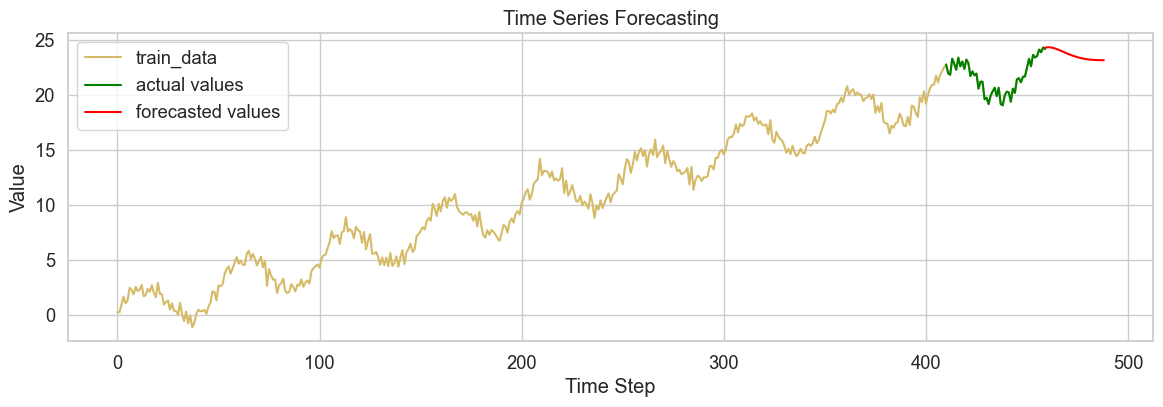

In [21]:
forecasted_values = forecast_model_on_raw_data(
    model=model_lstm,
    data_value=data_value,
    device=device,
    num_forecast_steps=30,
    prediction_start=410,
)

last_number = Data3.index[-1]
periods = 29
future_dates = pd.Series(range(last_number, last_number + 1 + periods))

# plt.rcParams['figure.figsize'] = [14, 4]
plt.plot(Data3.index, Data3.Value, label="train_data", color="y")
plt.plot(Data3.index[-50:], Data3.Value[-50:], label="actual values", color="green")
plt.plot(
    future_dates,
    scaler.inverse_transform(np.array(forecasted_values).reshape(-1, 1)).flatten(),
    label="forecasted values",
    color="red",
)

plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.title("Time Series Forecasting")
plt.grid(True)
plt.show()

Temporal Fusion Transformer

In [ ]:
from pytorch_forecasting.data.examples import get_stallion_data

data = get_stallion_data()

# add time index
data["time_idx"] = data["date"].dt.year * 12 + data["date"].dt.month
data["time_idx"] -= data["time_idx"].min()

# add additional features
data["month"] = data.date.dt.month.astype(str).astype(
    "category"
)  # categories have be strings
data["log_volume"] = np.log(data.volume + 1e-8)
data["avg_volume_by_sku"] = data.groupby(
    ["time_idx", "sku"], observed=True
).volume.transform("mean")
data["avg_volume_by_agency"] = data.groupby(
    ["time_idx", "agency"], observed=True
).volume.transform("mean")

# we want to encode special days as one variable and thus need to first reverse one-hot encoding
special_days = [
    "easter_day",
    "good_friday",
    "new_year",
    "christmas",
    "labor_day",
    "independence_day",
    "revolution_day_memorial",
    "regional_games",
    "fifa_u_17_world_cup",
    "football_gold_cup",
    "beer_capital",
    "music_fest",
]
data[special_days] = (
    data[special_days].apply(lambda x: x.map({0: "-", 1: x.name})).astype("category")
)
data.sample(10, random_state=521)

agency     sku     volume       date  industry_volume  soda_volume  \
291    Agency_25  SKU_03     0.5076 2013-01-01        492612703    718394219   
871    Agency_29  SKU_02     8.7480 2015-01-01        498567142    762225057   
19532  Agency_47  SKU_01     4.9680 2013-09-01        454252482    789624076   
2089   Agency_53  SKU_07    21.6825 2013-10-01        480693900    791658684   
9755   Agency_17  SKU_02   960.5520 2015-03-01        515468092    871204688   
7561   Agency_05  SKU_03  1184.6535 2014-02-01        425528909    734443953   
19204  Agency_11  SKU_05     5.5593 2017-08-01        623319783   1049868815   
8781   Agency_48  SKU_04  4275.1605 2013-03-01        509281531    892192092   
2540   Agency_07  SKU_21     0.0000 2015-10-01        544203593    761469815   
12084  Agency_21  SKU_03    46.3608 2017-04-01        589969396    940912941   

       avg_max_temp  price_regular  price_actual    discount  ...  \
291       25.845238    1264.162234   1152.473405  111.688829  ...   
871       27.584615    1316.098485   1296.804924   19.293561  ...   
19532     30.665957    1269.250000   1266.490490    2.759510  ...   
2089      29.197727    1193.842373   1128.124395   65.717978  ...   
9755      23.608120    1338.334248   1232.128069  106.206179  ...   
7561      28.668254    1369.556376   1161.135214  208.421162  ...   
19204     31.915385    1922.486644   1651.307674  271.178970  ...   
8781      26.767857    1761.258209   1546.059670  215.198539  ...   
2540      28.987755       0.000000      0.000000    0.000000  ...   
12084     32.478910    1675.922116   1413.571789  262.350327  ...   

       football_gold_cup  beer_capital  music_fest discount_in_percent  \
291                    -             -           -            8.835008   
871                    -             -           -            1.465966   
19532                  -             -           -            0.217413   
2089                   -  beer_capital           -            5.504745   
9755                   -             -  music_fest            7.935699   
7561                   -             -           -           15.218151   
19204                  -             -           -           14.105636   
8781                   -             -  music_fest           12.218455   
2540                   -             -           -            0.000000   
12084                  -             -           -           15.654088   

      timeseries time_idx month log_volume avg_volume_by_sku  \
291          228        0     1  -0.678062       1225.306376   
871          177       24     1   2.168825       1634.434615   
19532        322        8     9   1.603017       2625.472644   
2089         240        9    10   3.076505         38.529107   
9755         259       26     3   6.867508       2143.677462   
7561          21       13     2   7.077206       1566.643589   
19204         17       55     8   1.715472       1385.225478   
8781         151        2     3   8.360577       1757.950603   
2540         300       33    10 -18.420681          0.000000   
12084        181       51     4   3.836454       2034.293024   

      avg_volume_by_agency  
291              99.650400  
871              11.397086  
19532            48.295650  
2089           2511.035175  
9755            396.022140  
7561           1881.866367  
19204           109.699200  
8781           1925.272108  
2540           2418.719550  
12084           109.381800  

[10 rows x 31 columns]

In [ ]:
max_prediction_length = 6
max_encoder_length = 24
training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="volume",
    group_ids=["agency", "sku"],
    min_encoder_length=max_encoder_length
    // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["agency", "sku"],
    static_reals=["avg_population_2017", "avg_yearly_household_income_2017"],
    time_varying_known_categoricals=["special_days", "month"],
    variable_groups={
        "special_days": special_days
    },  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx", "price_regular", "discount_in_percent"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "volume",
        "log_volume",
        "industry_volume",
        "soda_volume",
        "avg_max_temp",
        "avg_volume_by_agency",
        "avg_volume_by_sku",
    ],
    target_normalizer=GroupNormalizer(
        groups=["agency", "sku"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(
    training, data, predict=True, stop_randomization=True
)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size * 10, num_workers=0
)

In [ ]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
MAE()(baseline_predictions.output, baseline_predictions.y)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


tensor(293.0088)

In [ ]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator="cpu",
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=8,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    # reduce_on_plateau_patience=1000,
)
print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Number of parameters in network: 13.5k


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.041686938347033554
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.041686938347033554
INFO: Restoring states from the checkpoint path at /content/.lr_find_29d59495-343e-47b5-8998-24ce7cf86aad.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_29d59495-343e-47b5-8998-24ce7cf86aad.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_29d59495-343e-47b5-8998-24ce7cf86aad.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_29d59495-343e-47b5-8998-24ce7cf86aad.ckpt


suggested learning rate: 0.041686938347033554


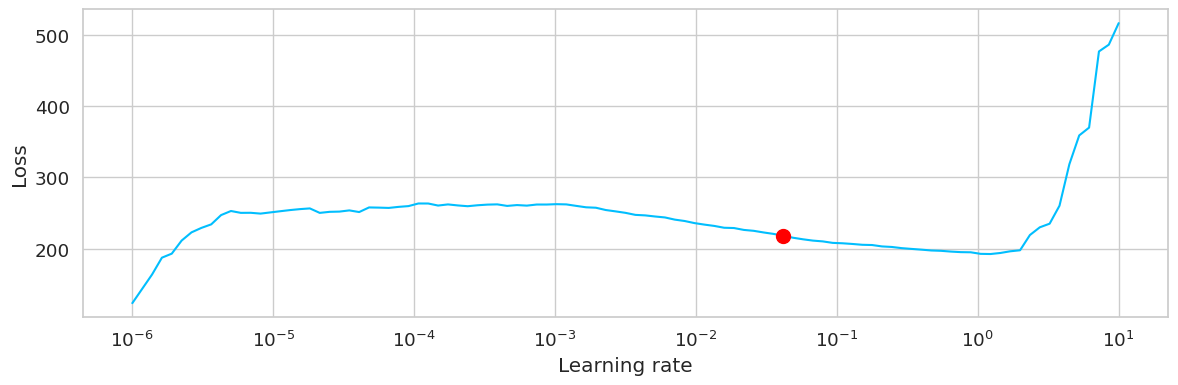

In [ ]:
# find optimal learning rate

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [ ]:
# configure network and trainer
early_stop_callback = EarlyStopping(
    monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min"
)
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Number of parameters in network: 29.4k


In [ ]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 1.3 K  | train
3  | prescalers                         | ModuleDict                      | 256    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 3.4 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 8.0 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.7 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K  | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
# Opcjonalny kod do optymalizacji hiperparametrów

import pickle
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import (
    optimize_hyperparameters,
)

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=200,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

In [ ]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [ ]:
# calcualte mean absolute error on validation set
predictions = best_tft.predict(
    val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu")
)
MAE()(predictions.output, predictions.y)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


tensor(268.5754)

In [ ]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


We can now also look at sample predictions directly which we plot with plot_prediction(). As you can see from the figures below, forecasts look rather accurate. If you wonder, the grey lines denote the amount of attention the model pays to different points in time when making the prediction. This is a special feature of the Temporal Fusion Transformer.

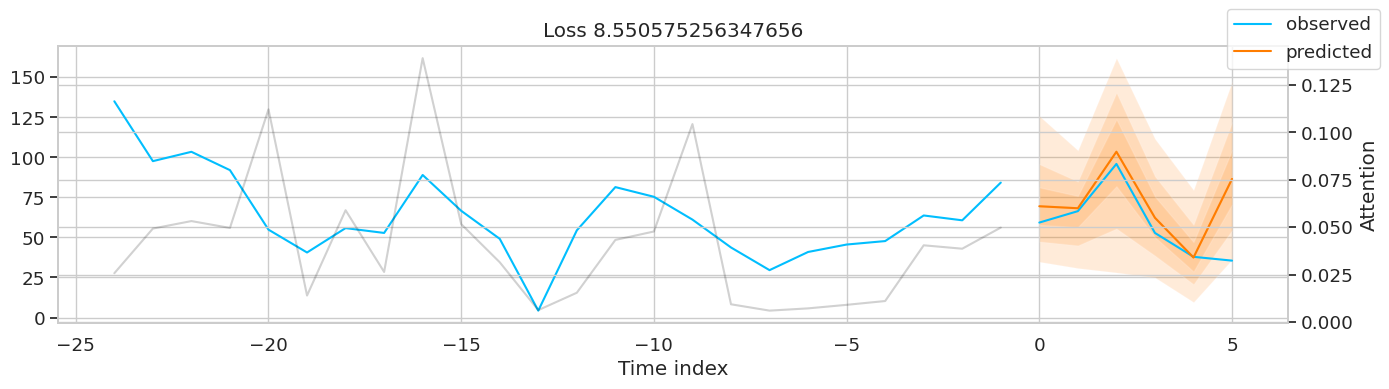

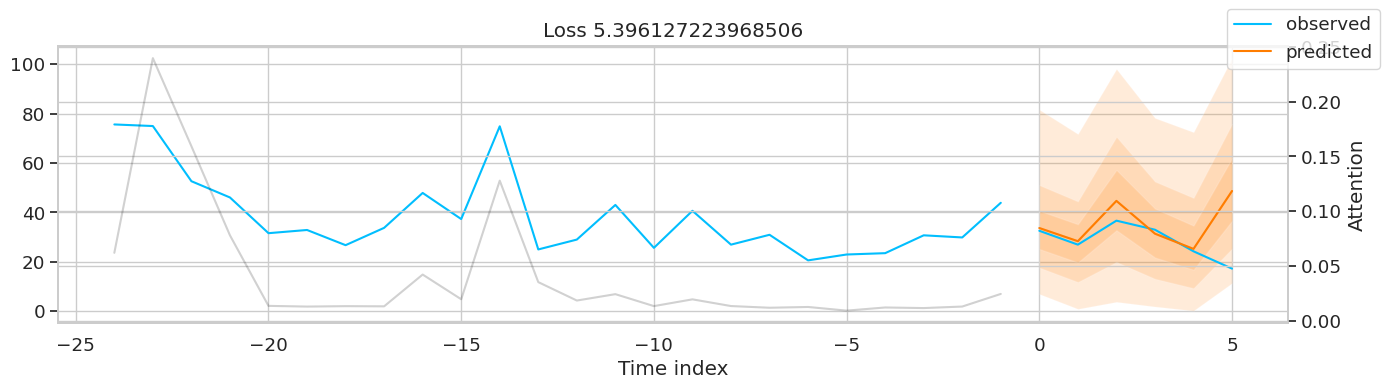

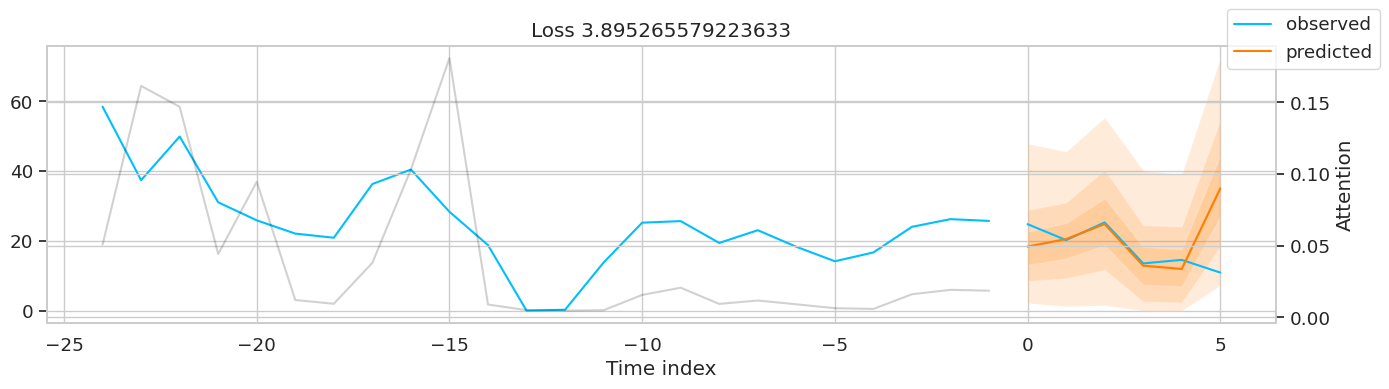

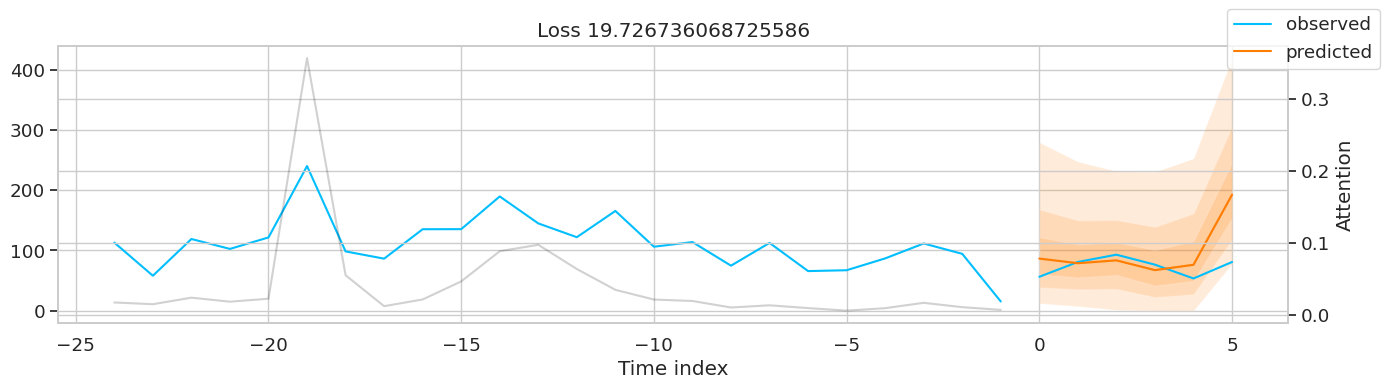

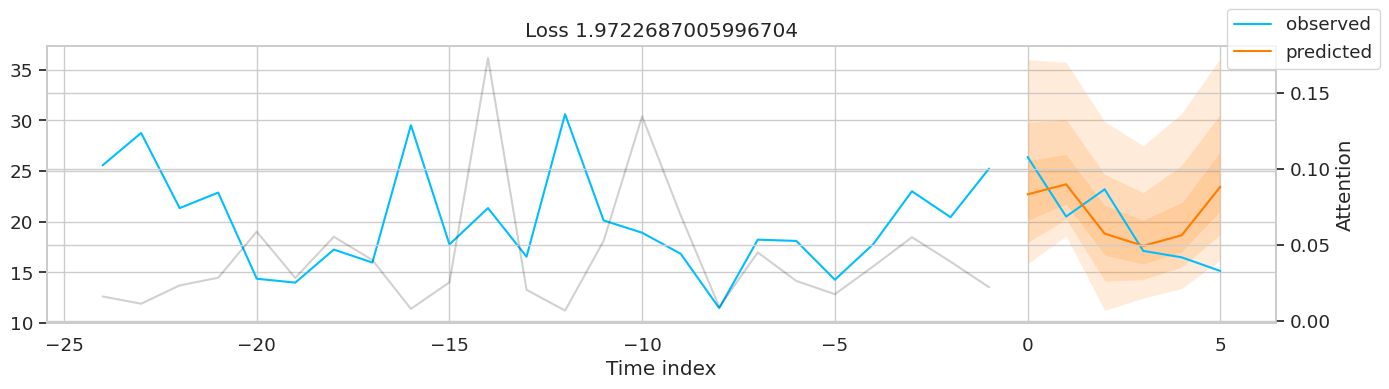

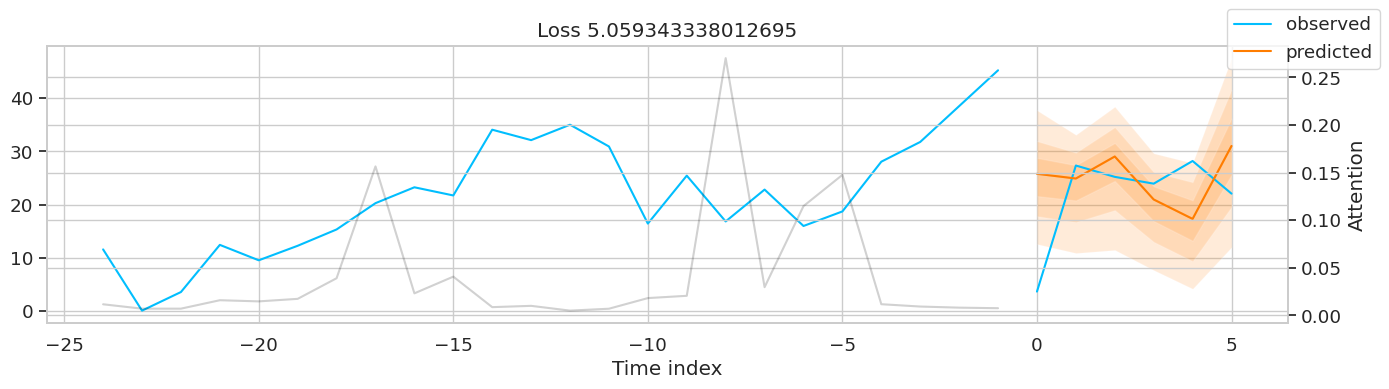

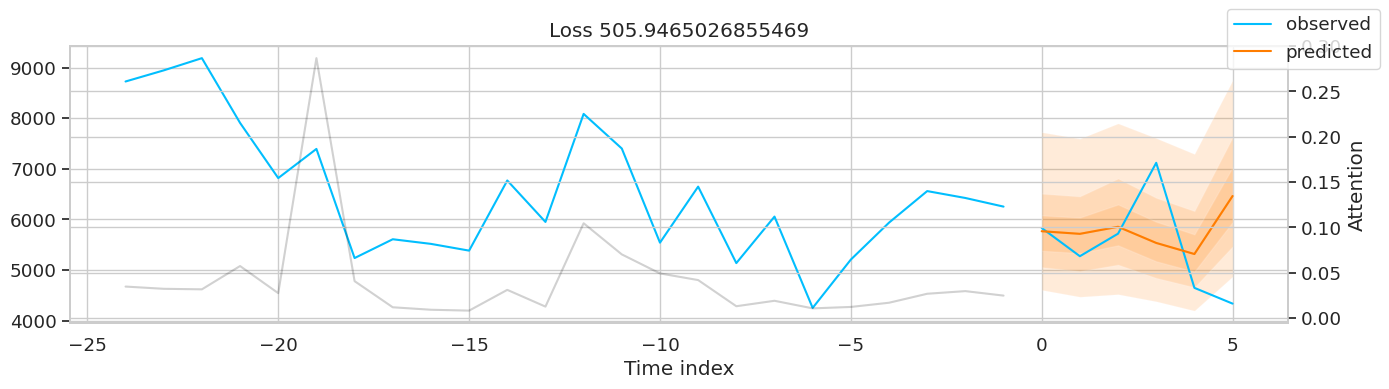

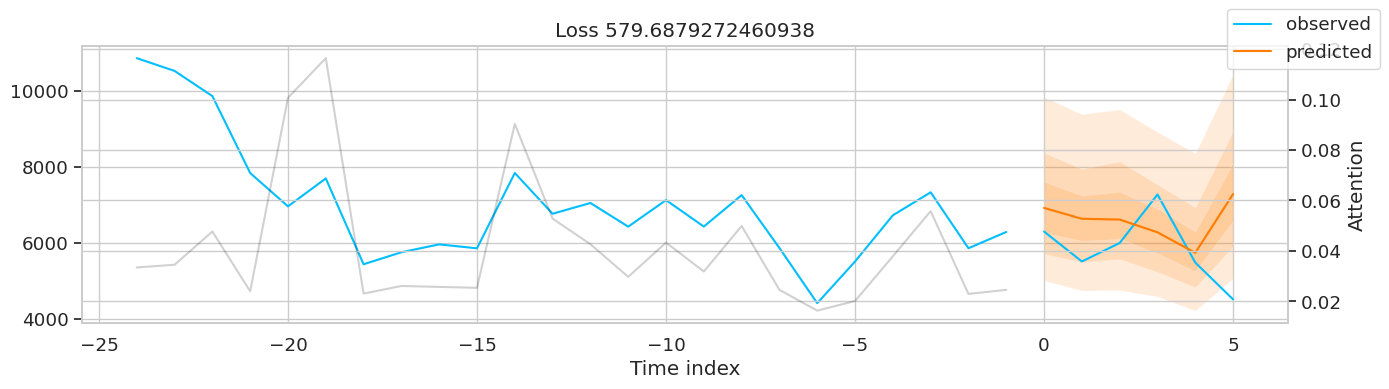

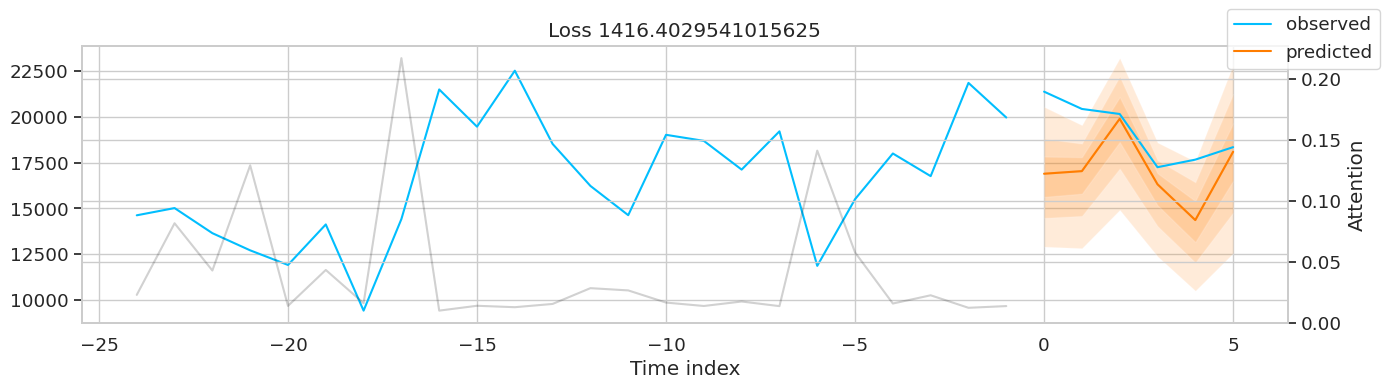

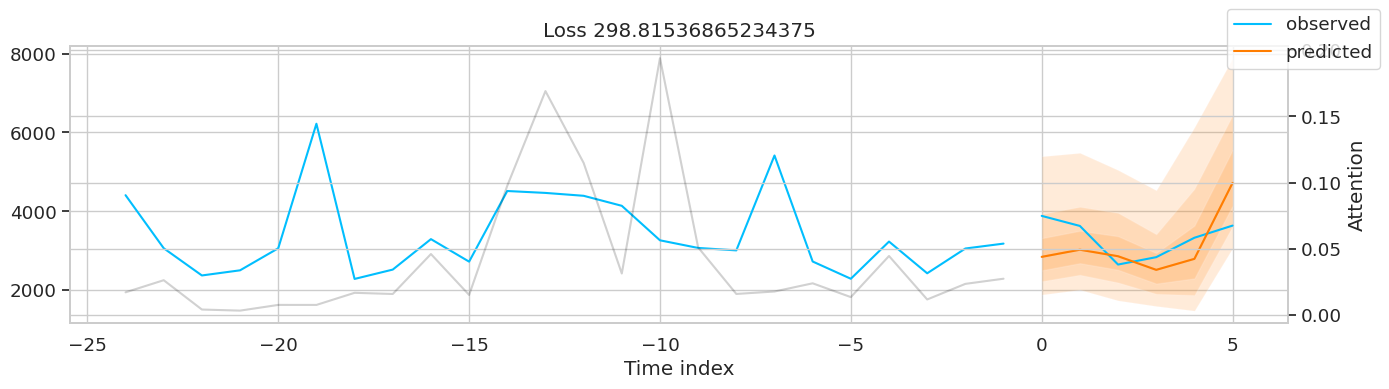

In [ ]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(
        raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True
    )

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


{'avg_population_2017': <Figure size 1000x500 with 2 Axes>,
 'avg_yearly_household_income_2017': <Figure size 1000x500 with 2 Axes>,
 'encoder_length': <Figure size 1000x500 with 2 Axes>,
 'volume_center': <Figure size 1000x500 with 2 Axes>,
 'volume_scale': <Figure size 1000x500 with 2 Axes>,
 'time_idx': <Figure size 1000x500 with 2 Axes>,
 'price_regular': <Figure size 1000x500 with 2 Axes>,
 'discount_in_percent': <Figure size 1000x500 with 2 Axes>,
 'relative_time_idx': <Figure size 1000x500 with 2 Axes>,
 'volume': <Figure size 1000x500 with 2 Axes>,
 'log_volume': <Figure size 1000x500 with 2 Axes>,
 'industry_volume': <Figure size 1000x500 with 2 Axes>,
 'soda_volume': <Figure size 1000x500 with 2 Axes>,
 'avg_max_temp': <Figure size 1000x500 with 2 Axes>,
 'avg_volume_by_agency': <Figure size 1000x500 with 2 Axes>,
 'avg_volume_by_sku': <Figure size 1000x500 with 2 Axes>,
 'agency': <Figure size 1000x500 with 2 Axes>,
 'sku': <Figure size 1000x500 with 2 Axes>,
 'special_days'

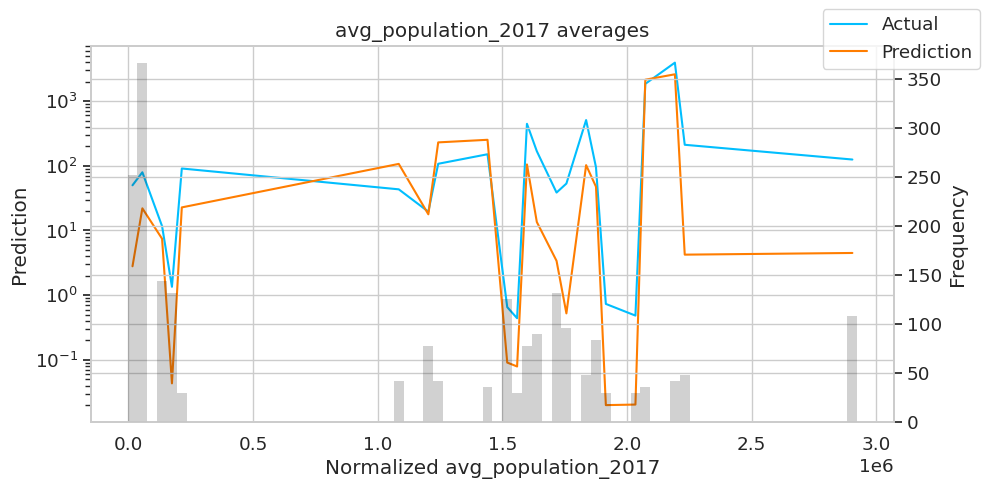

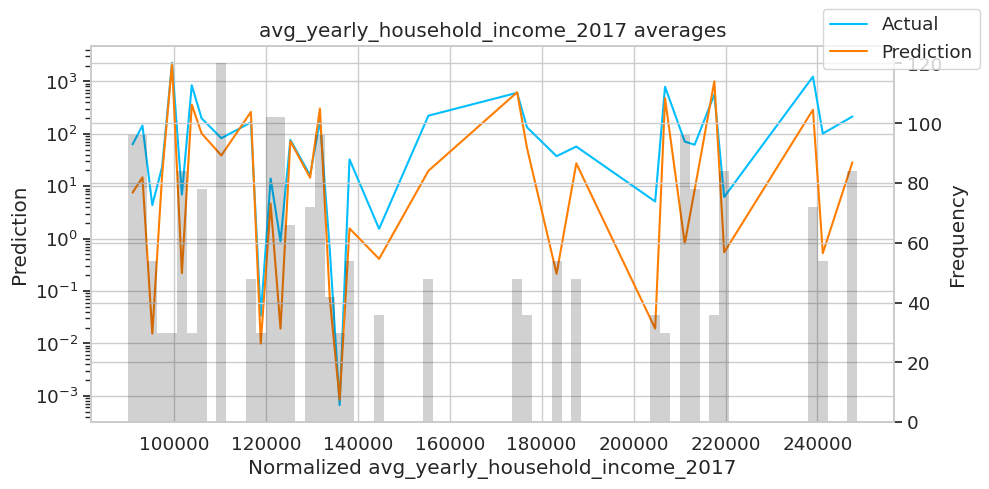

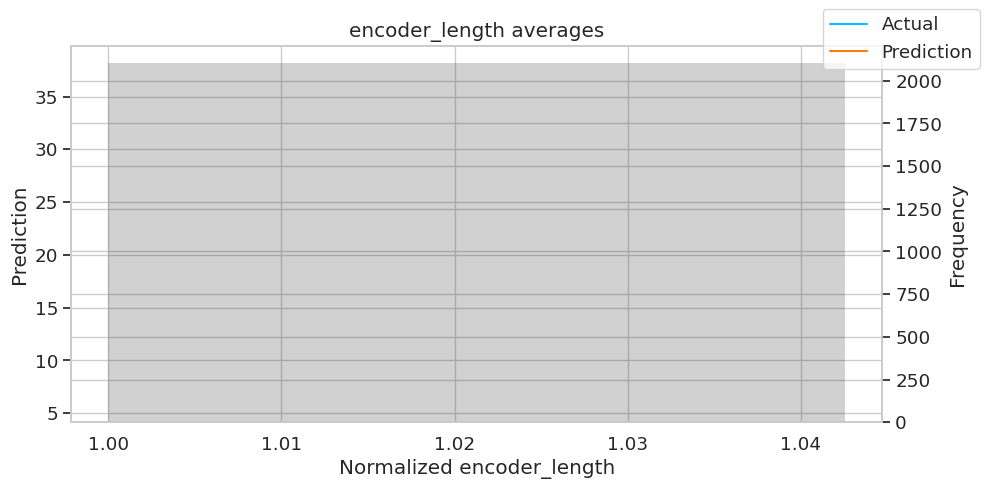

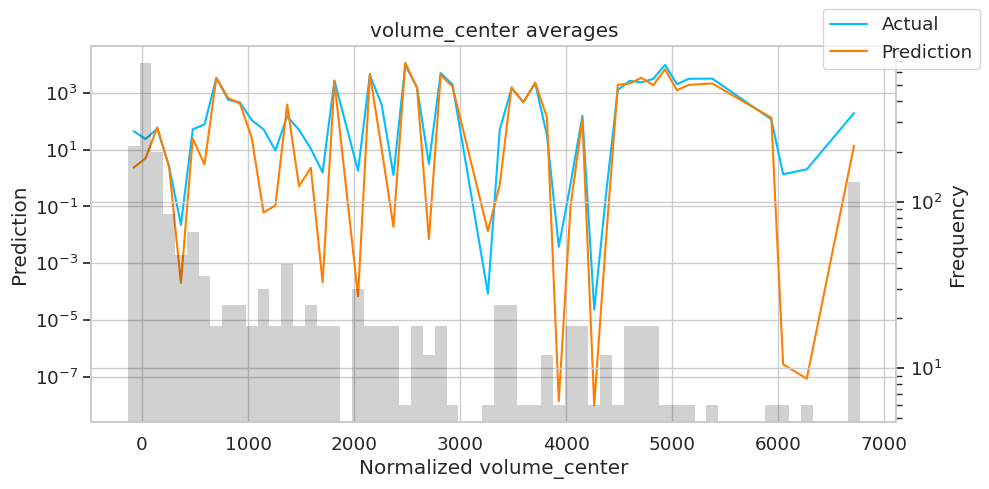

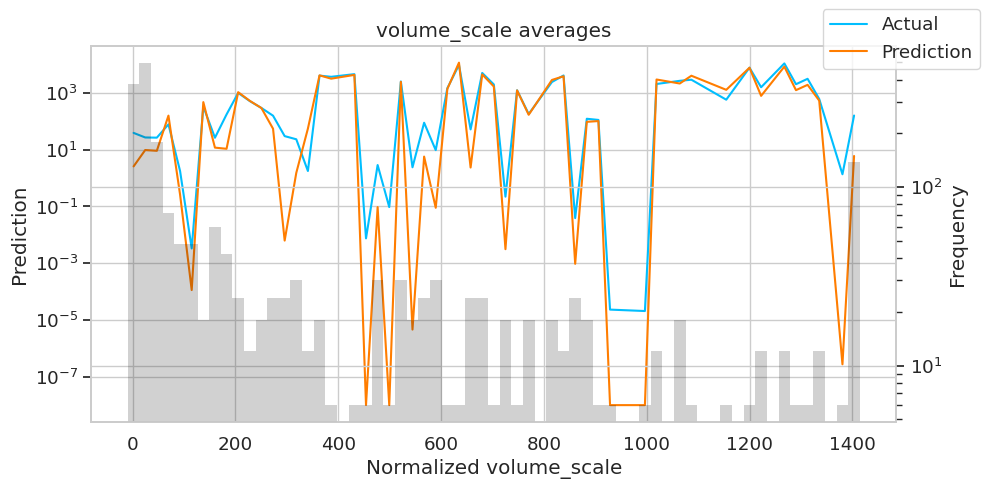

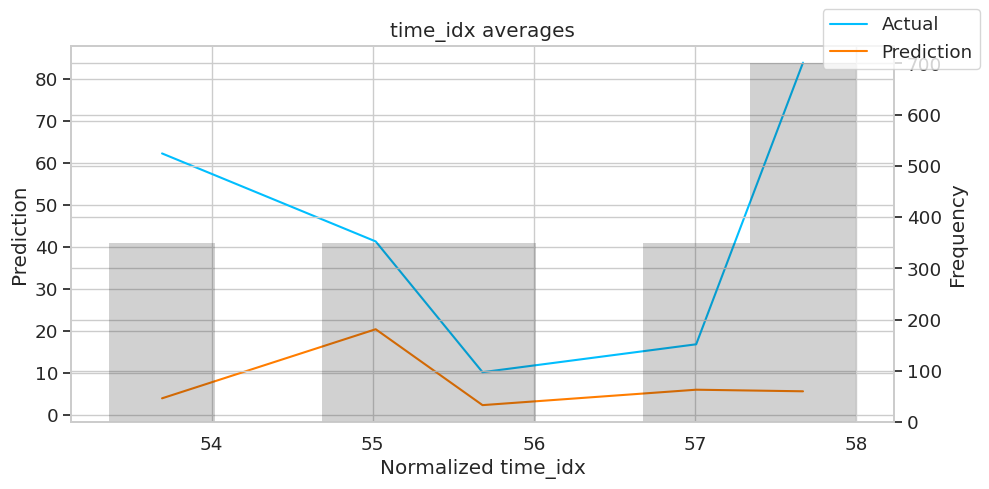

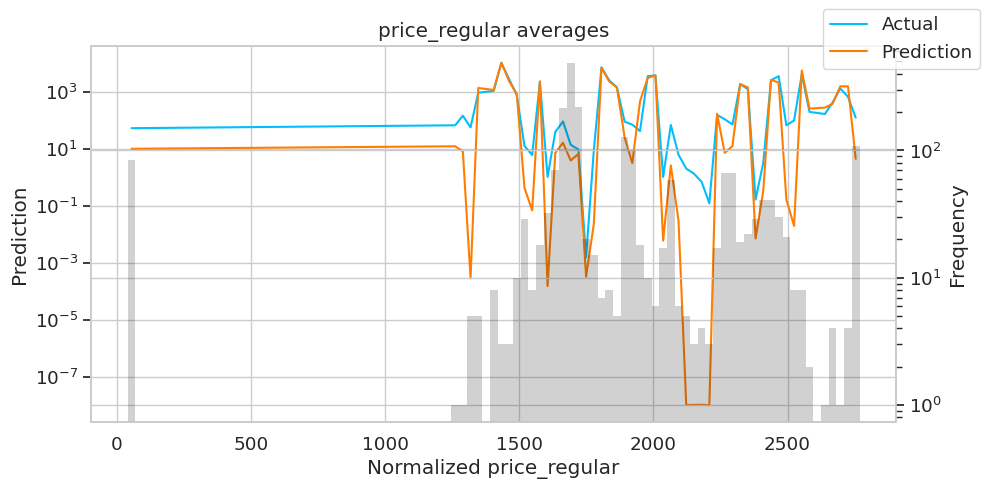

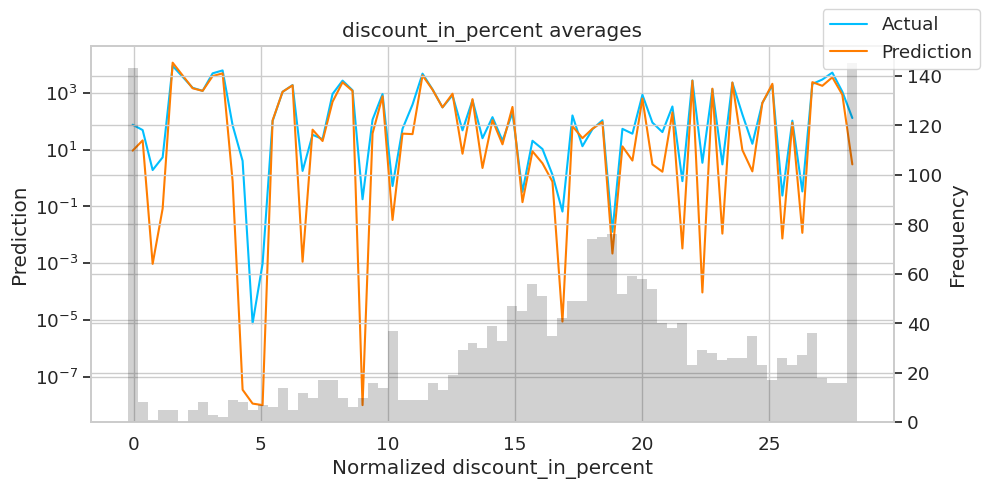

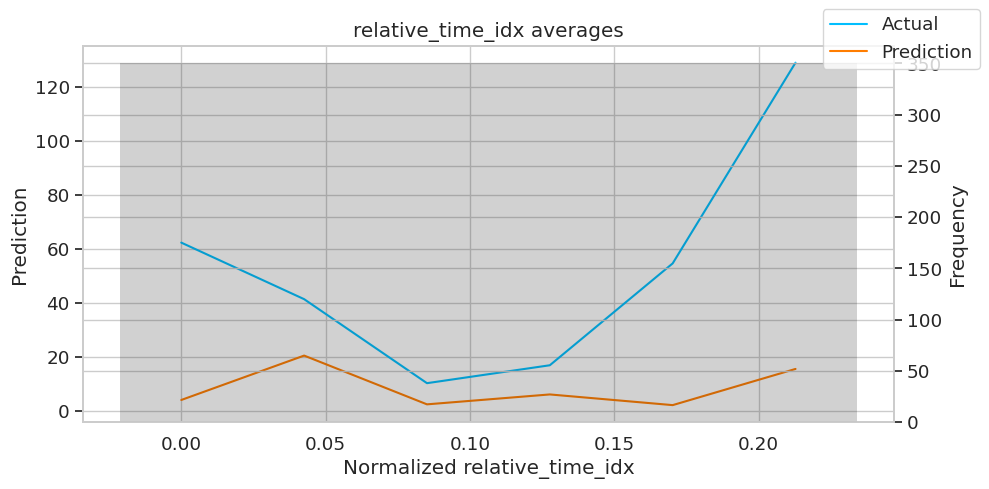

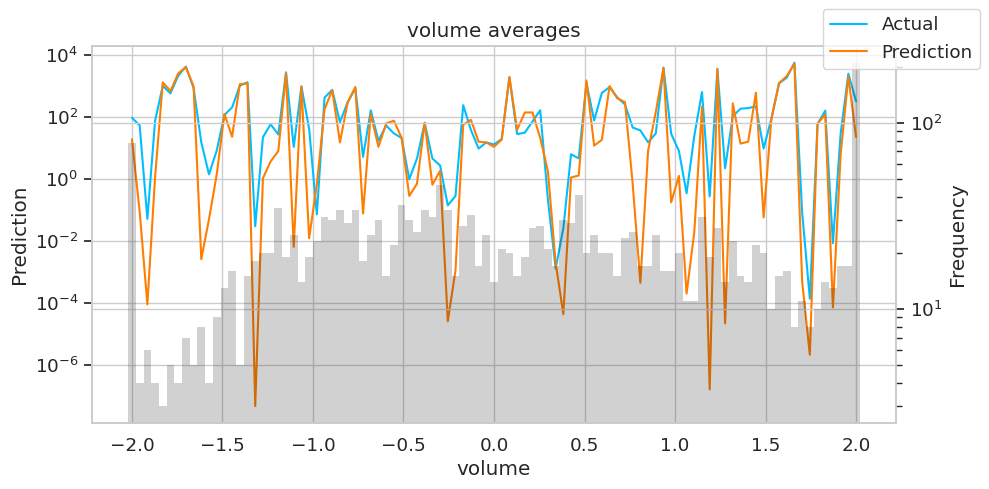

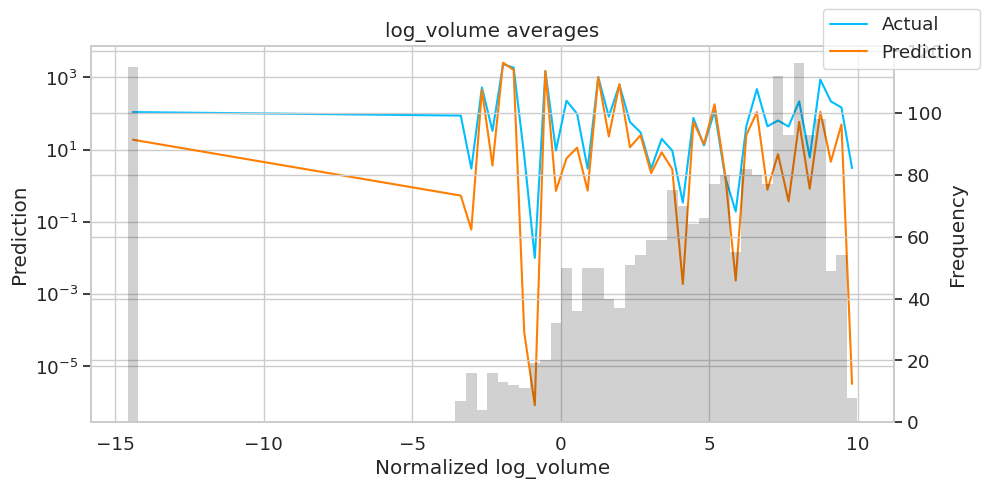

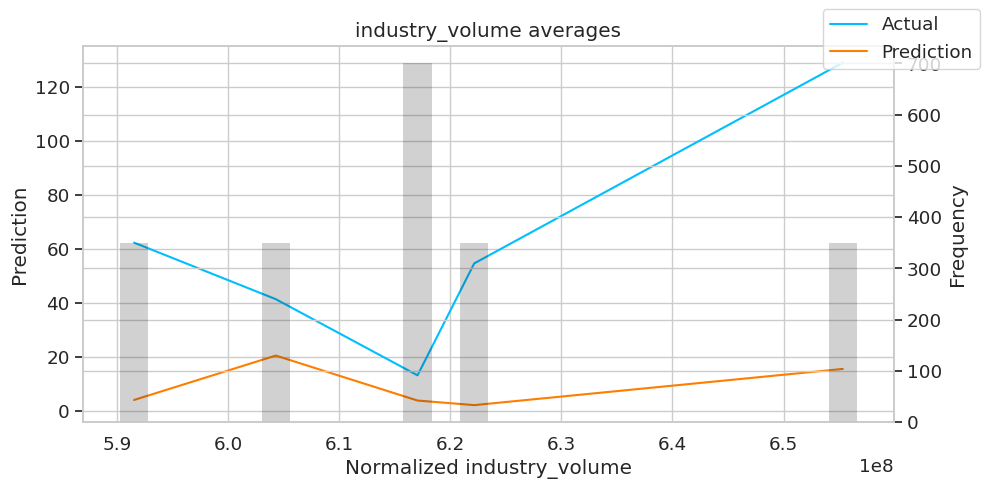

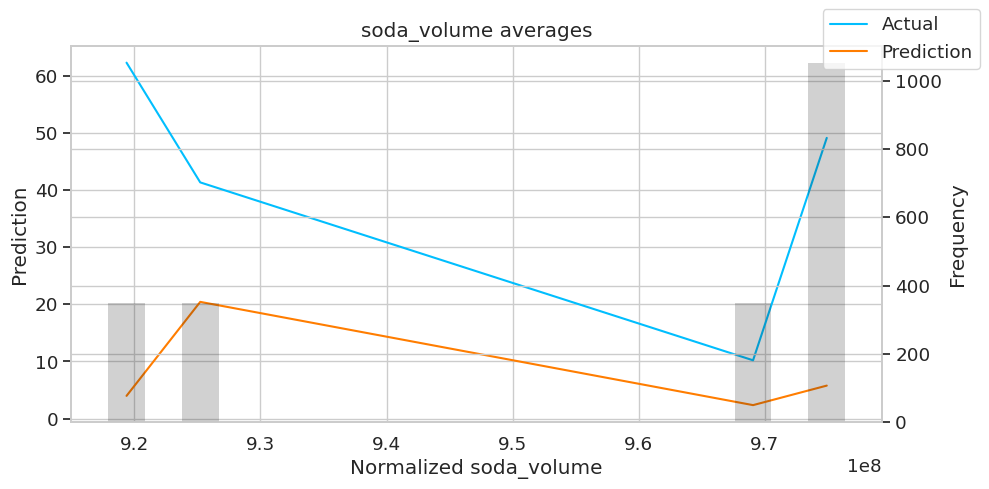

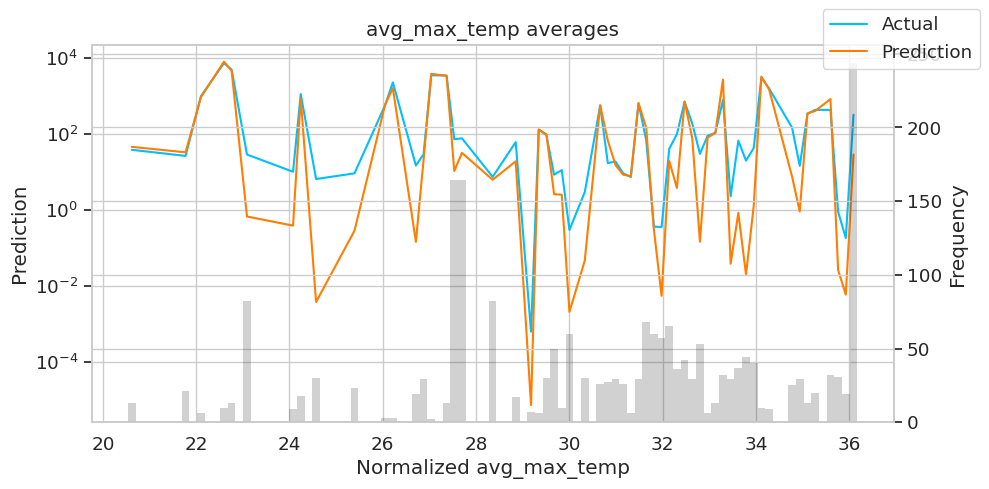

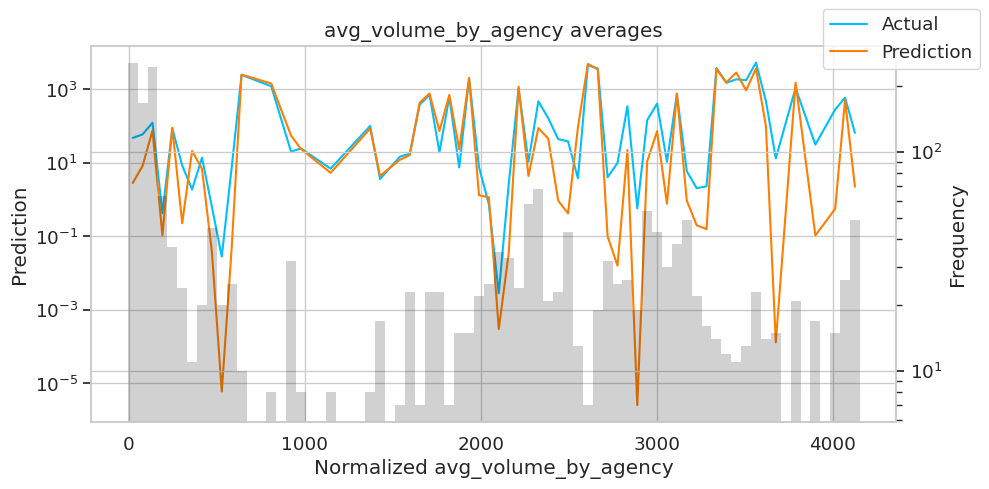

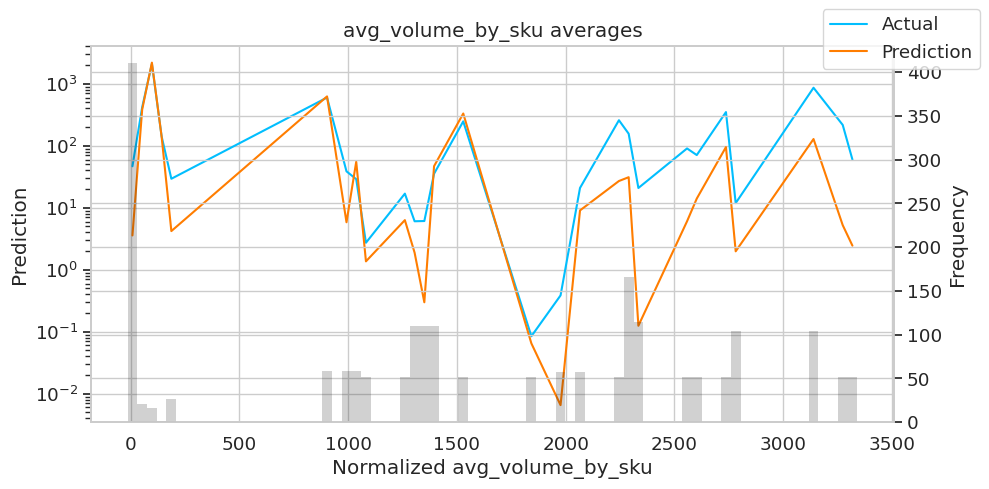

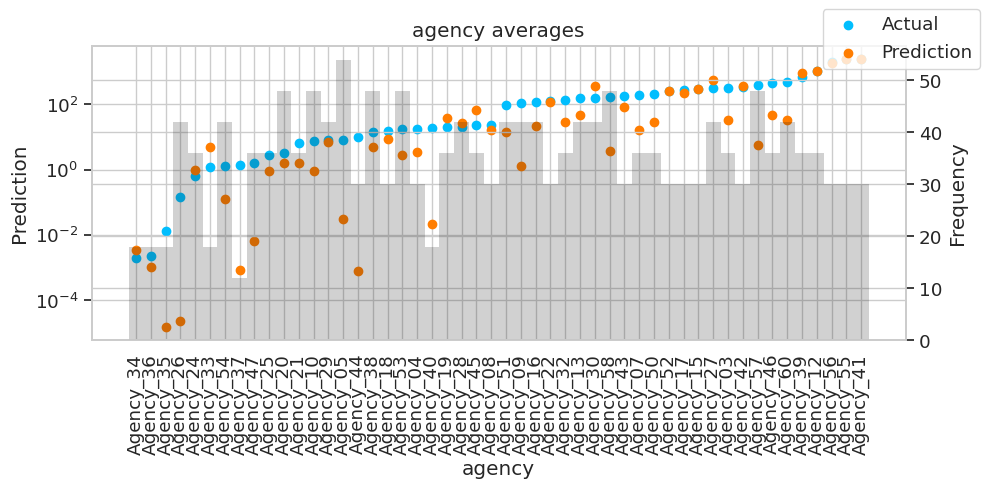

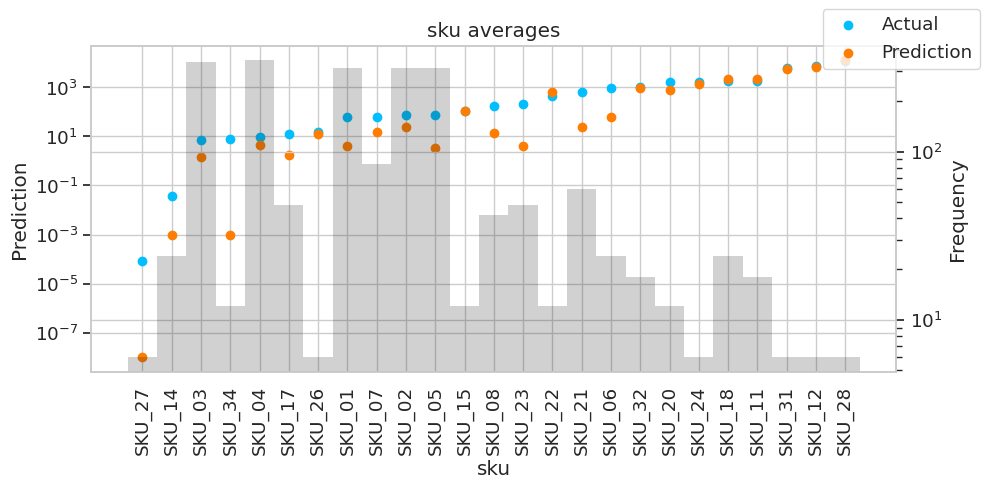

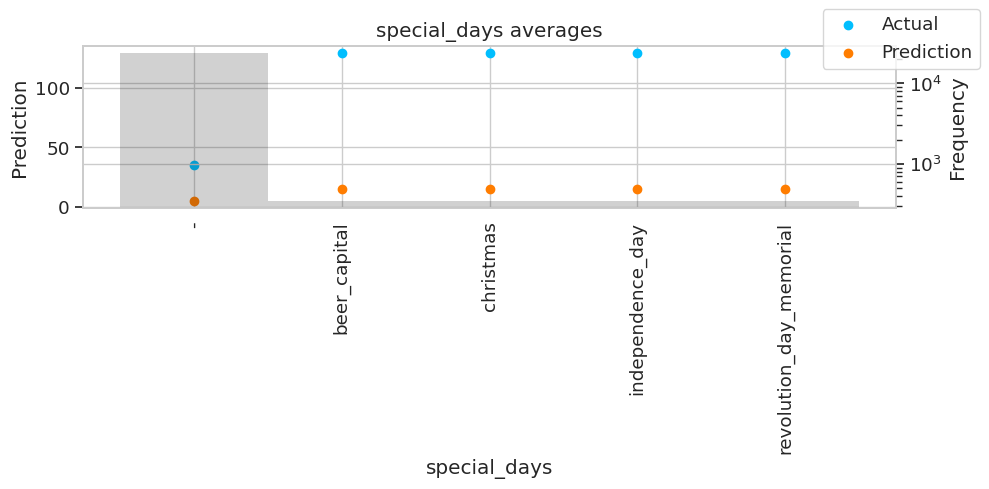

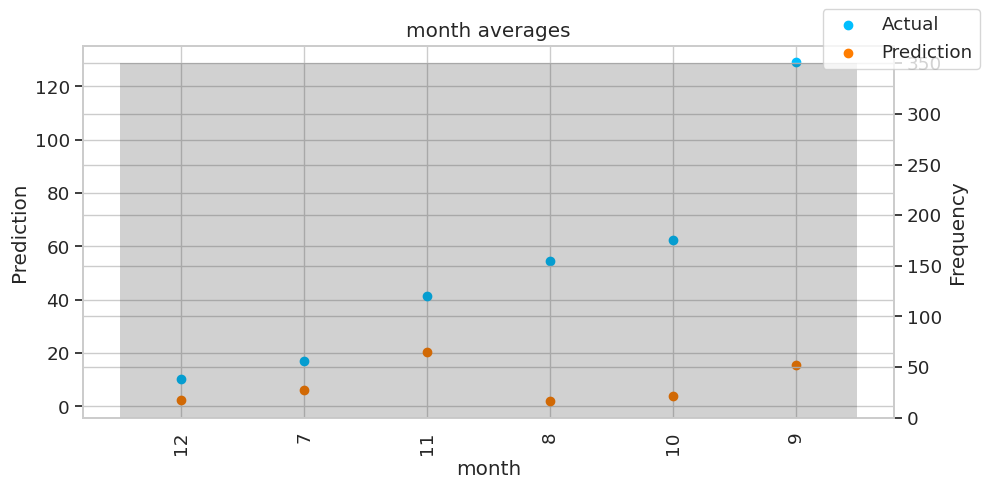

In [ ]:
predictions = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(
    predictions.x, predictions.output
)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

To predict on a subset of data we can filter the subsequences in a dataset using the filter() method. Here we predict for the subsequence in the training dataset that maps to the group ids “Agency_01” and “SKU_01” and whose first predicted value corresponds to the time index “15”. We output all seven quantiles. This means we expect a tensor of shape 1 x n_timesteps x n_quantiles = 1 x 6 x 7 as we predict for a single subsequence six time steps ahead and 7 quantiles for each time step.

In [ ]:
best_tft.predict(
    training.filter(
        lambda x: (x.agency == "Agency_01")
        & (x.sku == "SKU_01")
        & (x.time_idx_first_prediction == 15)
    ),
    mode="quantiles",
)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


tensor([[[ 64.0997,  93.2812, 115.5878, 135.3757, 150.0835, 163.9195, 180.6093],
         [ 61.0822,  93.2481, 116.1752, 134.6431, 151.9631, 167.8977, 181.6872],
         [ 58.1423,  88.5686, 110.9492, 129.1131, 145.4526, 161.6515, 177.6964],
         [ 65.9303,  91.1351, 110.3198, 128.1548, 140.7706, 154.5849, 176.4832],
         [ 61.0320,  88.1208, 107.8722, 125.2933, 137.4866, 149.6053, 164.1558],
         [ 51.5632,  79.3450,  98.7971, 115.3800, 128.8240, 142.1996, 152.7018]]])

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


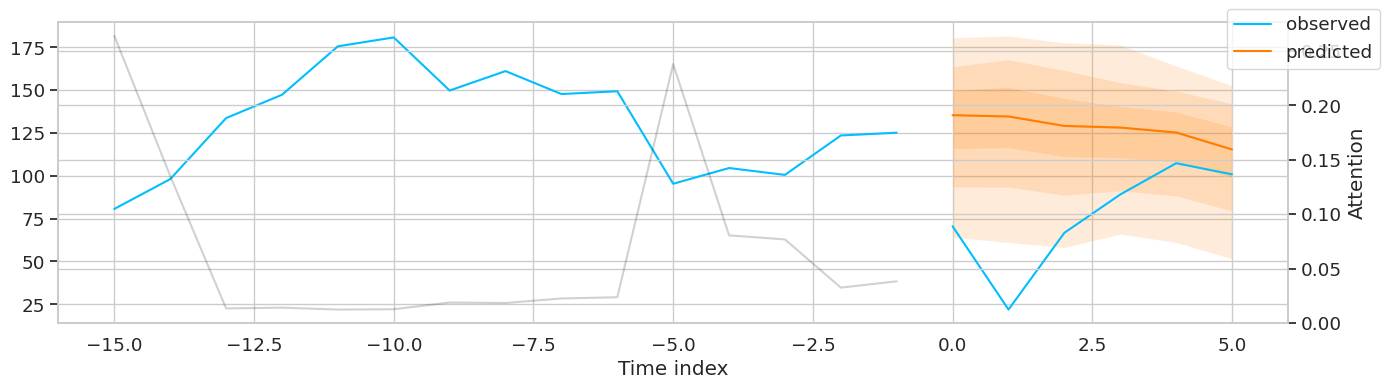

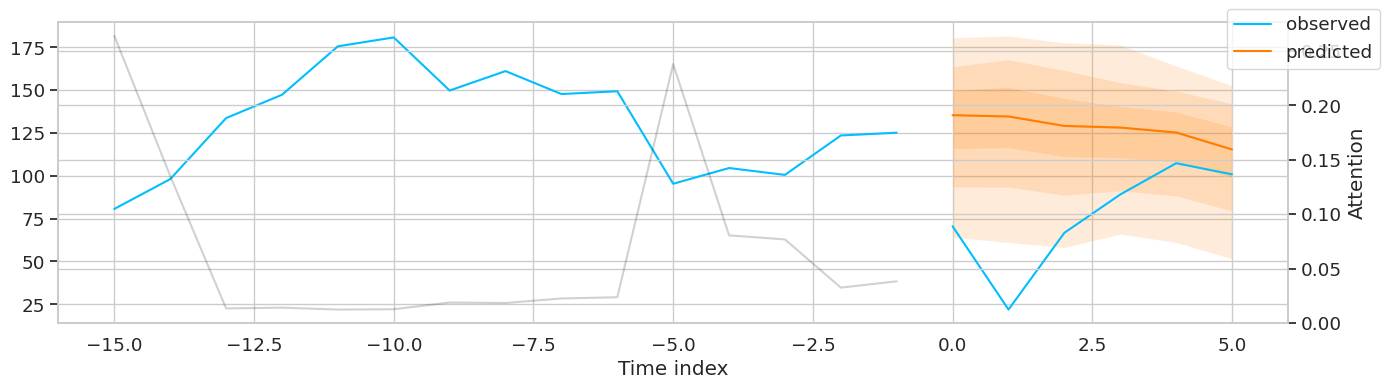

In [ ]:
raw_prediction = best_tft.predict(
    training.filter(
        lambda x: (x.agency == "Agency_01")
        & (x.sku == "SKU_01")
        & (x.time_idx_first_prediction == 15)
    ),
    mode="raw",
    return_x=True,
)
best_tft.plot_prediction(raw_prediction.x, raw_prediction.output, idx=0)

Predict on new data
Because we have covariates in the dataset, predicting on new data requires us to define the known covariates upfront.

In [ ]:
# select last 24 months from data (max_encoder_length is 24)
encoder_data = data[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]

# select last known data point and create decoder data from it by repeating it and incrementing the month
# in a real world dataset, we should not just forward fill the covariates but specify them to account
# for changes in special days and prices (which you absolutely should do but we are too lazy here)
last_data = data[lambda x: x.time_idx == x.time_idx.max()]
decoder_data = pd.concat(
    [
        last_data.assign(date=lambda x: x.date + pd.offsets.MonthBegin(i))
        for i in range(1, max_prediction_length + 1)
    ],
    ignore_index=True,
)

# add time index consistent with "data"
decoder_data["time_idx"] = (
    decoder_data["date"].dt.year * 12 + decoder_data["date"].dt.month
)
decoder_data["time_idx"] += (
    encoder_data["time_idx"].max() + 1 - decoder_data["time_idx"].min()
)

# adjust additional time feature(s)
decoder_data["month"] = decoder_data.date.dt.month.astype(str).astype(
    "category"
)  # categories have be strings

# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

In [ ]:
new_raw_predictions = best_tft.predict(new_prediction_data, mode="raw", return_x=True)

for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(
        new_raw_predictions.x,
        new_raw_predictions.output,
        idx=idx,
        show_future_observed=False,
    )

KeyError: 'Time'

The model has inbuilt interpretation capabilities due to how its architecture is build. Let’s see how that looks. We first calculate interpretations with interpret_output() and plot them subsequently with plot_interpretation().

In [ ]:
interpretation = best_tft.interpret_output(raw_predictions.output, reduction="sum")
best_tft.plot_interpretation(interpretation)

In [ ]:
dependency = best_tft.predict_dependency(
    val_dataloader.dataset,
    "discount_in_percent",
    np.linspace(0, 30, 30),
    show_progress_bar=True,
    mode="dataframe",
)

In [ ]:
# plotting median and 25% and 75% percentile
agg_dependency = dependency.groupby("discount_in_percent").normalized_prediction.agg(
    median="median", q25=lambda x: x.quantile(0.25), q75=lambda x: x.quantile(0.75)
)
ax = agg_dependency.plot(y="median")
ax.fill_between(agg_dependency.index, agg_dependency.q25, agg_dependency.q75, alpha=0.3)

## [LSTM using TF](https://)

In [ ]:
import yfinance as yf
from datetime import date

# Ustawiamy zakres dat od 1990-01-01 do dnia dzisiejszego
end_date = date.today().strftime("%Y-%m-%d")
start_date = "1990-01-01"

# Dane pobieramy z yahoo
df = yf.download("AAPL", start=start_date, end=end_date)

# Inspect the data
print(df.head())
print(df.info())

[*********************100%***********************]  1 of 1 completed

Price      Adj Close     Close      High       Low      Open     Volume
Ticker          AAPL      AAPL      AAPL      AAPL      AAPL       AAPL
Date                                                                   
1990-01-02  0.262129  0.332589  0.334821  0.312500  0.314732  183198400
1990-01-03  0.263889  0.334821  0.339286  0.334821  0.339286  207995200
1990-01-04  0.264769  0.335938  0.345982  0.332589  0.341518  221513600
1990-01-05  0.265648  0.337054  0.341518  0.330357  0.337054  123312000
1990-01-08  0.267408  0.339286  0.339286  0.330357  0.334821  101572800
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8811 entries, 1990-01-02 to 2024-12-20
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Adj Close, AAPL)  8811 non-null   float64
 1   (Close, AAPL)      8811 non-null   float64
 2   (High, AAPL)       8811 non-null   float64
 3   (Low, AAPL)        8811 non-null   float64
 4   (Open, 

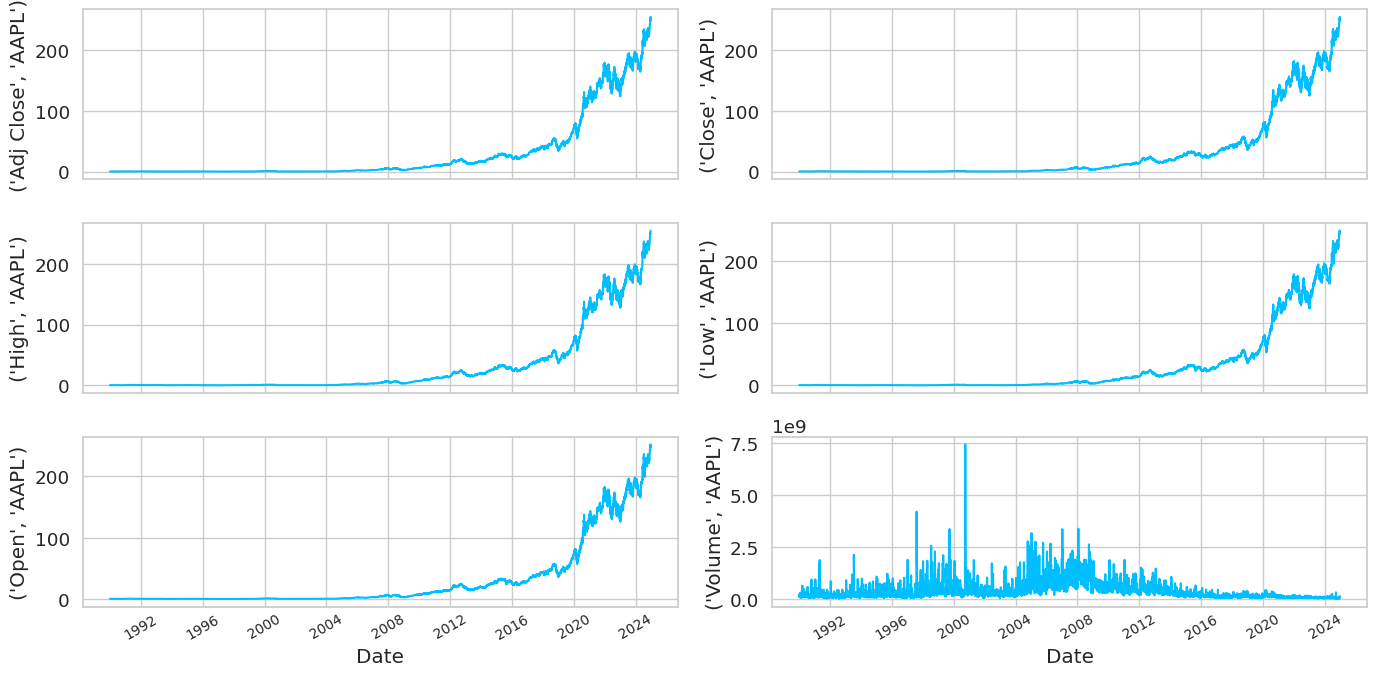

In [ ]:
import matplotlib.dates as mdates


def data_plot(df):
    # Plot line charts
    df_plot = df.copy()

    ncols = 2
    nrows = int(round(df_plot.shape[1] / ncols, 0))

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
    for i, ax in enumerate(fig.axes):
        sns.lineplot(data=df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    fig.tight_layout()
    plt.show()


# Plot the data
data_plot(df)

Temporal Fusion Transformer for benchmark data\

In [ ]:
group = ["group" for i in time_series]
data = pd.DataFrame({"Time": t, "Value": time_series})
data["group"] = group
data.sample(10, random_state=521)

Time      Value  group
69     69   4.496534  group
263   263  14.633860  group
304   304  16.153057  group
19     19   1.612942  group
71     71   5.282526  group
104   104   6.082864  group
213   213  12.971749  group
472   472  23.578654  group
164   164  10.646263  group
371   371  19.762506  group

In [ ]:
max_prediction_length = 50
max_encoder_length = 128
training_cutoff = data["Time"].max() - max_prediction_length
training_cutoff

training = TimeSeriesDataSet(
    data[lambda x: x.Time <= training_cutoff],
    time_idx="Time",
    target="Value",
    group_ids=["group"],
    min_encoder_length=max_encoder_length
    // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals=["Time"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["Value"],  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

In [ ]:
# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(
    training, data, predict=True, stop_randomization=True
)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size * 10, num_workers=0
)

In [ ]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator="cpu",
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=8,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    # reduce_on_plateau_patience=1000,
)
print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Number of parameters in network: 6.7k


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.025703957827688636
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.025703957827688636
INFO: Restoring states from the checkpoint path at /content/.lr_find_62d59b92-5a8b-40f0-b744-66102cbff505.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_62d59b92-5a8b-40f0-b744-66102cbff505.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_62d59b92-5a8b-40f0-b744-66102cbff505.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_62d59b92-5a8b-40f0-b744-66102cbff505.ckpt


suggested learning rate: 0.025703957827688636


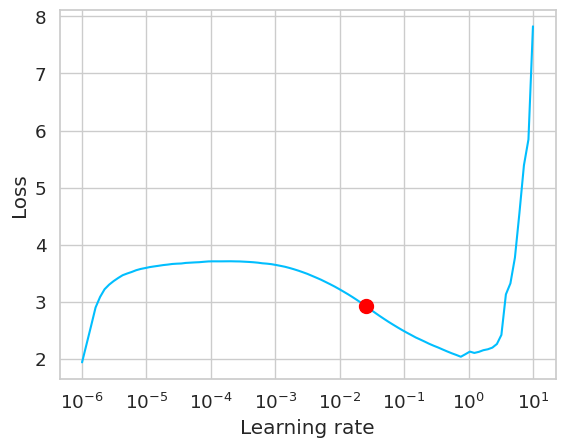

In [ ]:
# find optimal learning rate

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [ ]:
# configure network and trainer
early_stop_callback = EarlyStopping(
    monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min"
)
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Number of parameters in network: 18.6k


In [ ]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 0      | train
3  | prescalers                         | ModuleDict                      | 96     | train
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.8 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.2 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K  | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [ ]:
# calcualte mean absolute error on validation set
predictions = best_tft.predict(
    val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu")
)
MAE()(predictions.output, predictions.y)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


tensor(1.0636)

In [ ]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


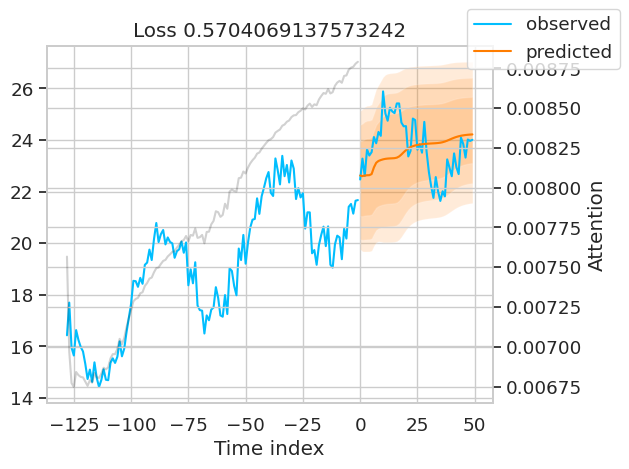

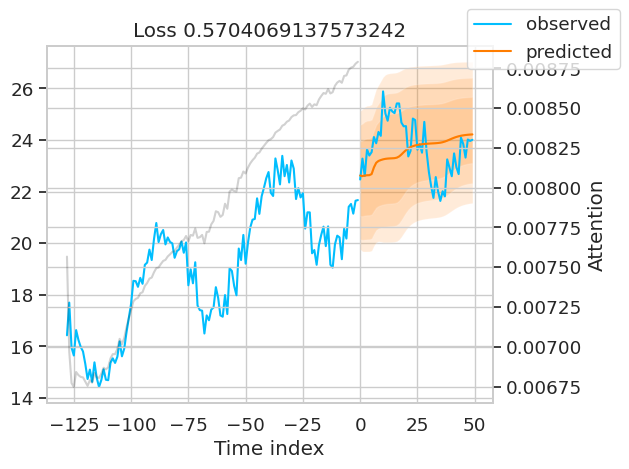

In [ ]:
# plot  examples
best_tft.plot_prediction(
    raw_predictions.x, raw_predictions.output, idx=0, add_loss_to_title=True
)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


{'encoder_length': <Figure size 1000x500 with 2 Axes>,
 'Value_center': <Figure size 1000x500 with 2 Axes>,
 'Value_scale': <Figure size 1000x500 with 2 Axes>,
 'Time': <Figure size 1000x500 with 2 Axes>,
 'relative_time_idx': <Figure size 1000x500 with 2 Axes>,
 'Value': <Figure size 1000x500 with 2 Axes>}

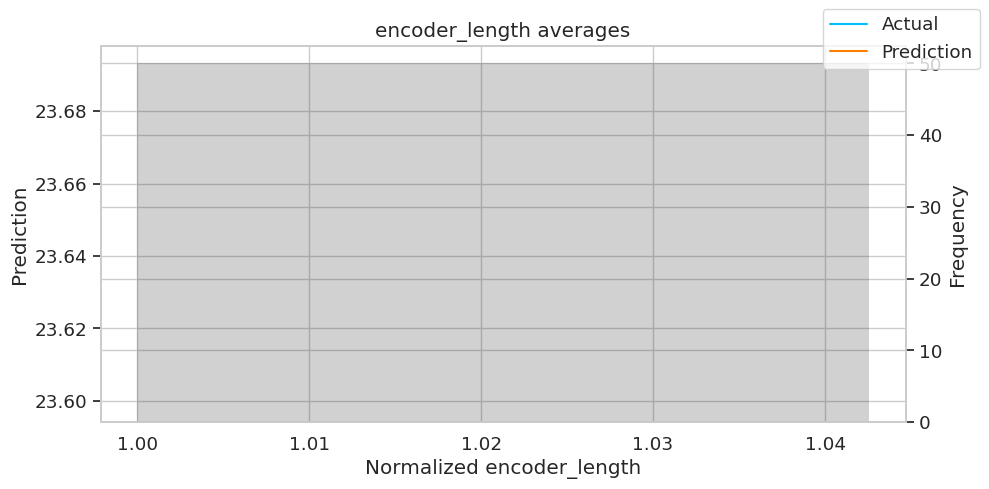

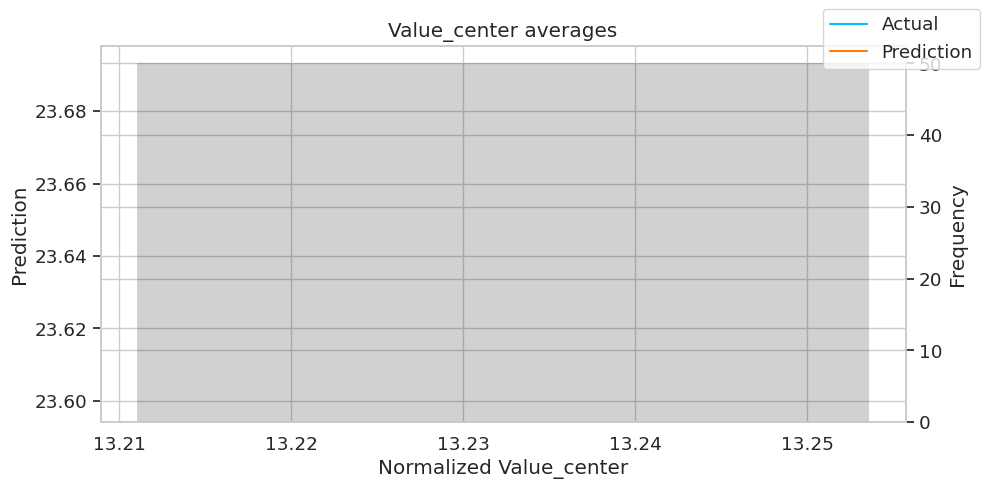

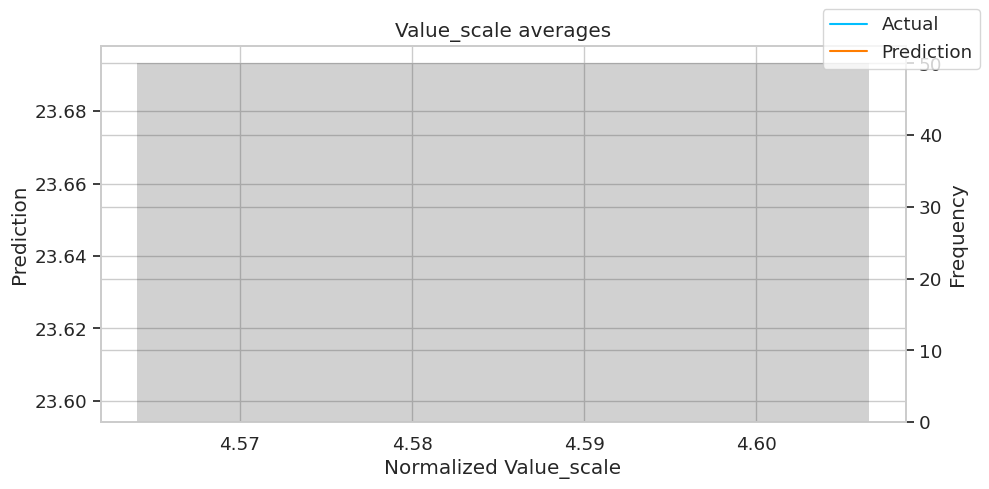

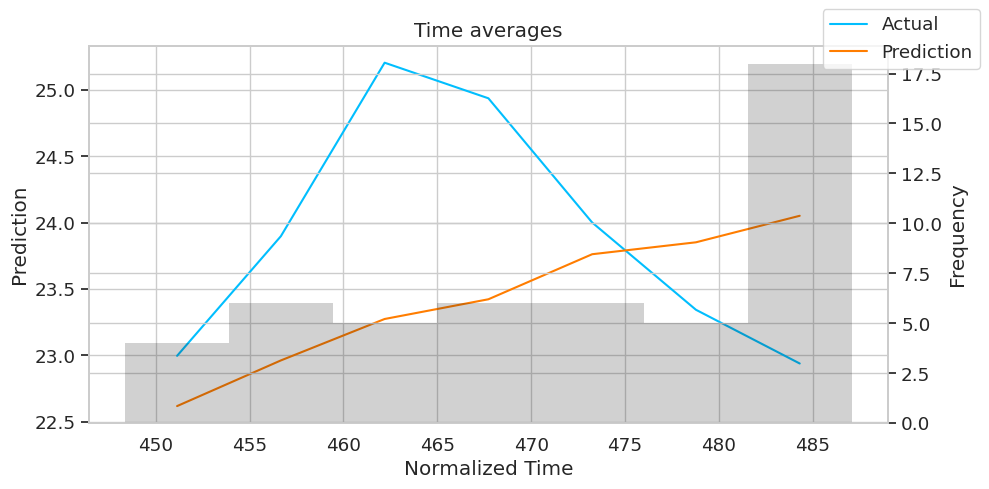

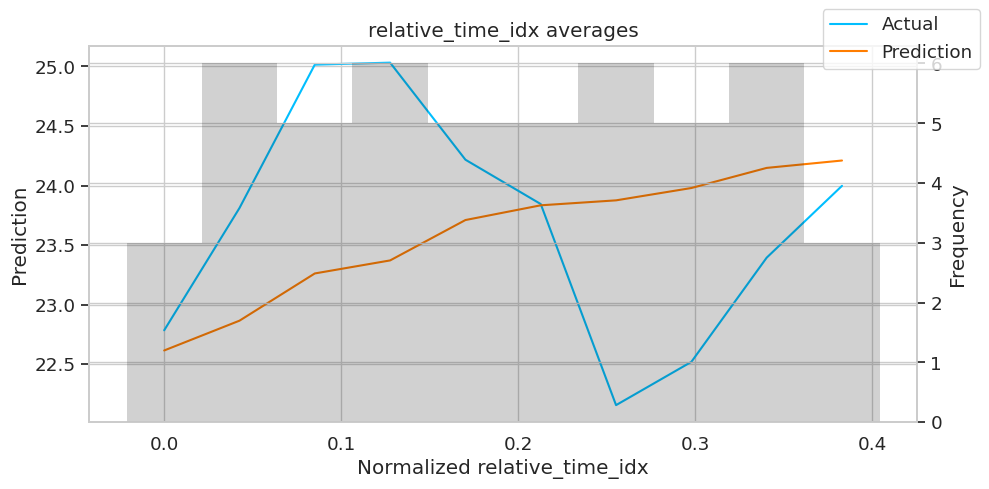

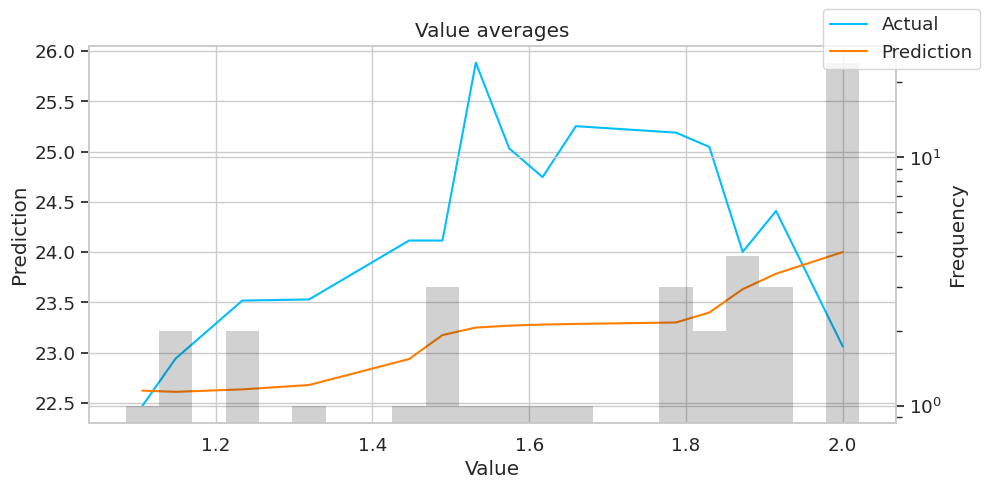

In [ ]:
predictions = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(
    predictions.x, predictions.output
)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

In [ ]:
best_tft.predict(
    training.filter(
        lambda x: (x.group == "group") & (x.time_idx_first_prediction == 115)
    ),
    mode="quantiles",
)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


tensor([[[ 3.6621,  4.1585,  4.9191,  6.3554,  7.7872,  8.5625,  9.0477],
         [ 3.5907,  4.1303,  4.9174,  6.3389,  7.8231,  8.6182,  9.1204],
         [ 3.5819,  4.1375,  4.9314,  6.3532,  7.8635,  8.6739,  9.1899],
         [ 3.5885,  4.1473,  4.9427,  6.3650,  7.8811,  8.6974,  9.2191],
         [ 3.5962,  4.1516,  4.9479,  6.3693,  7.8783,  8.6916,  9.2141],
         [ 3.6024,  4.1545,  4.9519,  6.3722,  7.8740,  8.6835,  9.2062],
         [ 3.5921,  4.1567,  4.9582,  6.3787,  7.8995,  8.7191,  9.2471],
         [ 3.5985,  4.1928,  4.9930,  6.4373,  8.0115,  8.8583,  9.4108],
         [ 3.7594,  4.3808,  5.1417,  6.6809,  8.3148,  9.1854,  9.8000],
         [ 3.9007,  4.5535,  5.2853,  6.8686,  8.5709,  9.4733, 10.1295],
         [ 3.9685,  4.6318,  5.3529,  6.9455,  8.6715,  9.5849, 10.2558],
         [ 3.9956,  4.6587,  5.3769,  6.9712,  8.6971,  9.6103, 10.2855],
         [ 4.0092,  4.6694,  5.3872,  6.9817,  8.7019,  9.6123, 10.2891],
         [ 4.0180,  4.6750,  5.3930,  

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


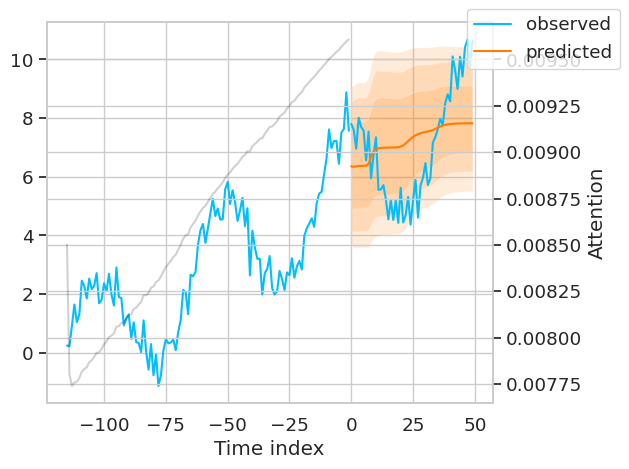

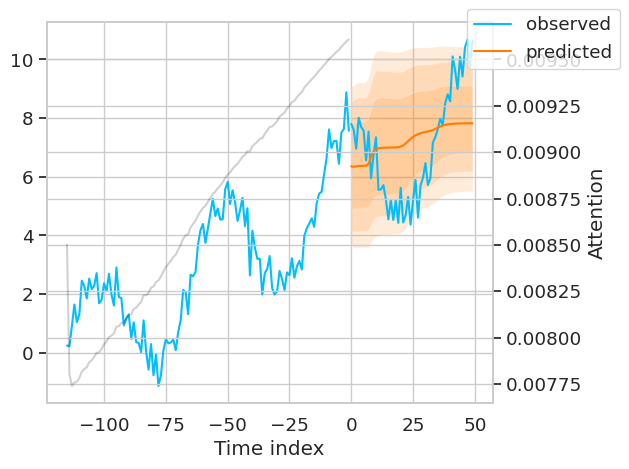

In [ ]:
raw_prediction = best_tft.predict(
    training.filter(
        lambda x: (x.group == "group") & (x.time_idx_first_prediction == 115)
    ),
    mode="raw",
    return_x=True,
)
best_tft.plot_prediction(raw_prediction.x, raw_prediction.output, idx=0)

In [ ]:
future_steps = 50
last_time = data["Time"].max()

future_data = pd.DataFrame(
    {
        "Time": list(range(last_time + 1, last_time + 1 + future_steps)),
        "Value": [0] * future_steps,  # Wartości mogą być puste (np. NaN)
        "group": ["group"] * future_steps,  # Taka sama grupa jak podczas treningu
    }
)

In [ ]:
new_prediction_data = pd.concat([data, future_data]).reset_index(drop=True)

In [ ]:
new_prediction_data[-25:]

Time  Value  group
525   525    0.0  group
526   526    0.0  group
527   527    0.0  group
528   528    0.0  group
529   529    0.0  group
530   530    0.0  group
531   531    0.0  group
532   532    0.0  group
533   533    0.0  group
534   534    0.0  group
535   535    0.0  group
536   536    0.0  group
537   537    0.0  group
538   538    0.0  group
539   539    0.0  group
540   540    0.0  group
541   541    0.0  group
542   542    0.0  group
543   543    0.0  group
544   544    0.0  group
545   545    0.0  group
546   546    0.0  group
547   547    0.0  group
548   548    0.0  group
549   549    0.0  group

In [ ]:
new_prediction_dataset = TimeSeriesDataSet.from_dataset(
    training,
    new_prediction_data,
    predict=True,  # Przewidujemy przyszłe wartości
    stop_randomization=True,  # Utrzymujemy sekwencję bez losowego podziału
)

In [ ]:
new_prediction_loader = new_prediction_dataset.to_dataloader(
    train=False, batch_size=1, num_workers=0
)

In [ ]:
raw_predictions = best_tft.predict(new_prediction_loader, mode="raw", return_x=True)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
raw_predictions.x

{'encoder_cat': tensor([], size=(1, 128, 0), dtype=torch.int64),
 'encoder_cont': tensor([[[ 1.0000e+00,  1.0306e+01, -4.2513e+00,  1.1355e+00, -1.0000e+00,
           -6.3276e-01],
          [ 1.0000e+00,  1.0306e+01, -4.2513e+00,  1.1432e+00, -9.9219e-01,
           -8.1906e-01],
          [ 1.0000e+00,  1.0306e+01, -4.2513e+00,  1.1509e+00, -9.8438e-01,
           -6.4757e-01],
          [ 1.0000e+00,  1.0306e+01, -4.2513e+00,  1.1586e+00, -9.7656e-01,
           -1.3592e+00],
          [ 1.0000e+00,  1.0306e+01, -4.2513e+00,  1.1663e+00, -9.6875e-01,
           -1.0939e+00],
          [ 1.0000e+00,  1.0306e+01, -4.2513e+00,  1.1739e+00, -9.6094e-01,
           -1.3258e+00],
          [ 1.0000e+00,  1.0306e+01, -4.2513e+00,  1.1816e+00, -9.5312e-01,
           -9.7688e-01],
          [ 1.0000e+00,  1.0306e+01, -4.2513e+00,  1.1893e+00, -9.4531e-01,
           -1.6951e+00],
          [ 1.0000e+00,  1.0306e+01, -4.2513e+00,  1.1970e+00, -9.3750e-01,
           -1.7713e+00],
          

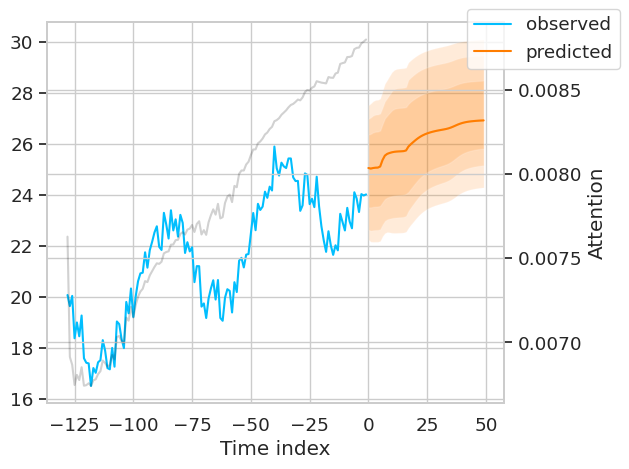

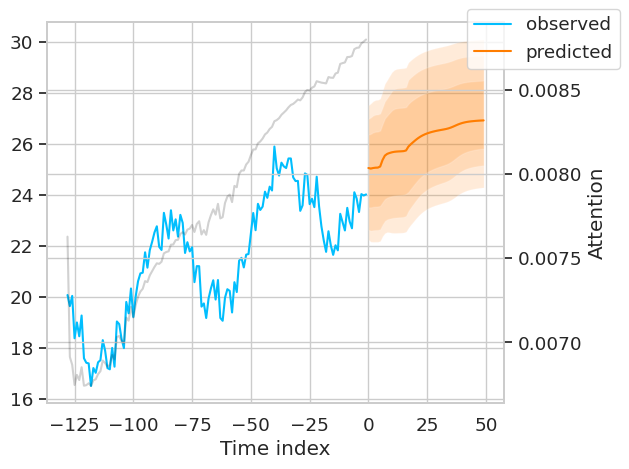

In [ ]:
best_tft.plot_prediction(
    raw_predictions.x, raw_predictions.output, idx=0, show_future_observed=False
)

In [ ]:
# 1. Uzyskaj predykcje dla nowych danych
predictions = best_tft.predict(new_prediction_loader)

# 2. Połącz dane historyczne i przewidywane
data_with_predictions = new_prediction_data.copy()

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


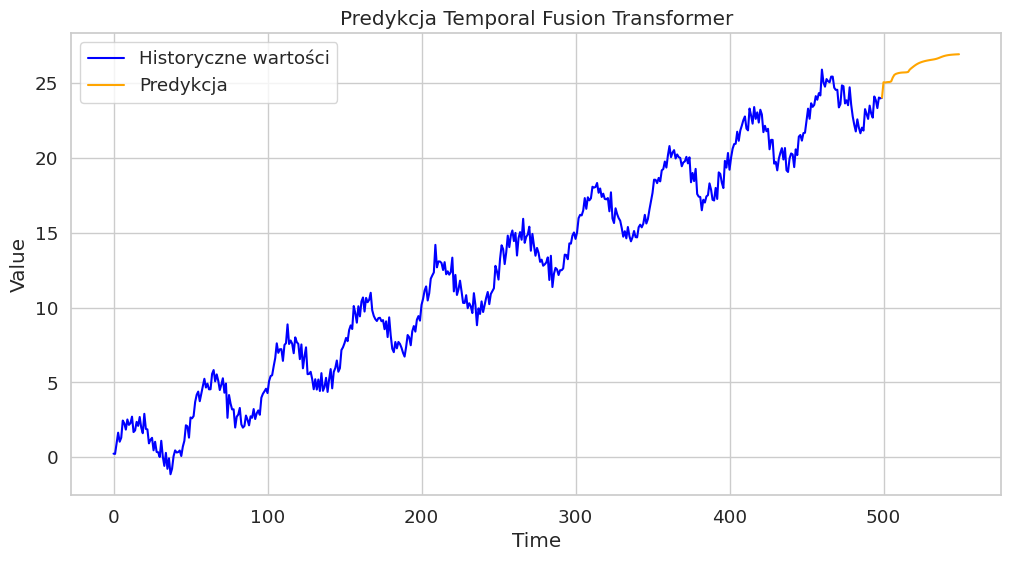

In [ ]:
# 3. Wstaw predykcje do kolumny Value (dla przyszłych kroków)
data_with_predictions.loc[data_with_predictions["Time"] > 499, "Value"] = (
    predictions.squeeze().numpy()
)

# 4. Wykres: dane historyczne i predykcje
plt.figure(figsize=(12, 6))
plt.plot(
    data_with_predictions.loc[data_with_predictions["Time"] <= 499, "Time"],
    data_with_predictions.loc[data_with_predictions["Time"] <= 499, "Value"],
    label="Historyczne wartości",
    color="blue",
)
plt.plot(
    data_with_predictions.loc[data_with_predictions["Time"] >= 499, "Time"],
    data_with_predictions.loc[data_with_predictions["Time"] >= 499, "Value"],
    label="Predykcja",
    color="orange",
)
# plt.axvline(x=500, color='gray', linestyle='--', label="Początek predykcji")
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Predykcja Temporal Fusion Transformer")
plt.legend()
plt.grid(True)
plt.show()